In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
from scipy.stats import ks_2samp
import math
import mpl_style
import csv
import hex_scatter as hs
from matplotlib.ticker import MaxNLocator
import scipy.stats.distributions as dist

H0 = 70.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [2]:
hdulist1 = fits.open('../lookup_redpas_cut.fits')
redpas_data = hdulist1[1].data
redpas_ind = redpas_data['redpas_ind']
redpas_pfeatures = redpas_data['redpas_pfeatures']
redpas_psmooth = redpas_data['redpas_psmooth']
redpas_color = redpas_data['redpas_color']
redpas_sfr = redpas_data['redpas_sfr']
redpas_mr = redpas_data['redpas_mr']
redpas_mass = redpas_data['redpas_mass']
redpas_galnum = redpas_data['redpas_galnum']

hdulist2 = fits.open('../lookup_redact_cut.fits')
redact_data = hdulist2[1].data
redact_ind = redact_data['redact_ind']
redact_pfeatures = redact_data['redact_pfeatures']
redact_psmooth = redact_data['redact_psmooth']
redact_color = redact_data['redact_color']
redact_sfr = redact_data['redact_sfr']
redact_mr = redact_data['redact_mr']
redact_mass = redact_data['redact_mass']
redact_galnum = redact_data['redact_galnum']

hdulist3 = fits.open('../lookup_bluact_cut.fits')
bluact_data = hdulist3[1].data
bluact_ind = bluact_data['bluact_ind']
bluact_pfeatures = bluact_data['bluact_pfeatures']
bluact_psmooth = bluact_data['bluact_psmooth']
bluact_color = bluact_data['bluact_color']
bluact_sfr = bluact_data['bluact_sfr']
bluact_mr = bluact_data['bluact_mr']
bluact_mass = bluact_data['bluact_mass']
bluact_galnum = bluact_data['bluact_galnum']

hdulist4 = fits.open('../lookup_all_cut.fits')
all_data = hdulist4[1].data
halo_mass = all_data['halo_mass'] #in units of log(Mhalo/(Msun/h))
pfeatures = all_data['pfeatures']
psmooth = all_data['psmooth']
color = all_data['color']
ssfr = all_data['ssfr']
M_r = all_data['M_r']
mass = all_data['mass']
z = all_data['z']
centsat = all_data['centsat']
galaxy_num = all_data['galaxy_num']
group_num = all_data['group_num']

hdulist5 = fits.open('../lookup_spiral_cut.fits')
spiral_data = hdulist5[1].data
spiral_ind = spiral_data['spiral_ind']

hdulist6 = fits.open('../lookup_int_cut.fits')
int_data = hdulist6[1].data
int_ind = int_data['int_ind']

hdulist7 = fits.open('../lookup_smooth_cut.fits')
smooth_data = hdulist7[1].data
smooth_ind = smooth_data['smooth_ind']

group_list = {}
with open('../lookup_group_cut.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        introw = [int(i) for i in row]
        group_list[introw[0]] = introw[1:]

In [3]:
hdulist1 = fits.open('../lookup_redpas.fits')
redpas_data = hdulist1[1].data
redpas_pfeatures_all = redpas_data['redpas_pfeatures']
redpas_color_all = redpas_data['redpas_color']
redpas_sfr_all = redpas_data['redpas_sfr']
redpas_mr_all = redpas_data['redpas_mr']
redpas_mass_all = redpas_data['redpas_mass']

hdulist2 = fits.open('../lookup_redact.fits')
redact_data = hdulist2[1].data
redact_pfeatures_all = redact_data['redact_pfeatures']
redact_color_all = redact_data['redact_color']
redact_sfr_all = redact_data['redact_sfr']
redact_mr_all = redact_data['redact_mr']
redact_mass_all = redact_data['redact_mass']

hdulist3 = fits.open('../lookup_bluact.fits')
bluact_data = hdulist3[1].data
bluact_pfeatures_all = bluact_data['bluact_pfeatures']
bluact_color_all = bluact_data['bluact_color']
bluact_sfr_all = bluact_data['bluact_sfr']
bluact_mr_all = bluact_data['bluact_mr']
bluact_mass_all = bluact_data['bluact_mass']

Above cell gets lists from lookup tables. Note that group_list is a dictionary with the group number as the key and a list of member IDs as the value

In [4]:
#Magnitude limit calculation
z_lim = 0.06
d = cosmo.luminosity_distance(z_lim).to(u.pc)
m = 17 #min brightness we can observe
M_limit = m - 5*math.log(d.value,10) + 5 #absolute magnitude of min brightness we can observe
adj_M_limit = M_limit - 5*math.log(h,10)
print(adj_M_limit) #so we exclude galaxies dimmer than this bc they won't be mass complete

-19.3715041683


In this cell, we use group_list to calculate the average pspiral and ssfr of the satellites of each central

In [5]:
cent_pspiral = []
sat_pspiral_edit = [] #array of pspiral only for groups with centrals
sat_pspiral_all = [] #pspiral of satellites for all groups

cent_ssfr = []
sat_ssfr = []

VLG_cent_ssfr_pas_sat = [] #ssfr of central galaxies with N > 5 with less than 1/2 star forming fraction
VLG_cent_ssfr_act_sat = [] #same as above but greater than 1/2 star forming fraction
VLG_cent_pfeat_smooth_sat = [] #pfeatures of central galaxies with at least 3 satellites with less than 0.2 pfeatures fraction
VLG_cent_pfeat_int_sat = []
VLG_cent_pfeat_spiral_sat = [] #same as above but greater than 0.8 pfeatures fraction
VLG_cent_avg_pfeat_spiral = [] #These three use the average pfeatures of satellites rather than the fraction of type
VLG_cent_avg_pfeat_smooth = []
VLG_cent_avg_pfeat_int = []

LG_cent_ssfr_pas_sat = [] #ssfr of central galaxies with 2 > N >=5 with less than 1/2 star forming fraction
LG_cent_ssfr_act_sat = [] #same as above but greater than 1/2 star forming fraction
LG_cent_pfeat_smooth_sat = [] #pfeatures of central galaxies with at least 3 satellites with less than 0.2 pfeatures fraction
LG_cent_pfeat_int_sat = []
LG_cent_pfeat_spiral_sat = [] #same as above but greater than 0.8 pfeatures fraction
LG_cent_avg_pfeat_spiral = [] #These three use the average pfeatures of satellites rather than the fraction of type
LG_cent_avg_pfeat_smooth = []
LG_cent_avg_pfeat_int = []

SG_cent_ssfr_pas_sat = [] #ssfr of central galaxies with N = 2 with less than 1/2 star forming fraction (pairs)
SG_cent_ssfr_act_sat = [] #same as above but greater than 1/2 star forming fraction
SG_cent_pfeat_smooth_sat = [] #pfeatures of central galaxies with at least 3 satellites with less than 0.2 pfeatures fraction
SG_cent_pfeat_int_sat = []
SG_cent_pfeat_spiral_sat = [] #same as above but greater than 0.8 pfeatures fraction
SG_cent_avg_pfeat_spiral = [] #These three use the average pfeatures of satellites rather than the fraction of type
SG_cent_avg_pfeat_smooth = []
SG_cent_avg_pfeat_int = []

AG_cent_ssfr_pas_sat = []
AG_cent_ssfr_act_sat = []
AG_cent_pfeat_smooth_sat = []
AG_cent_pfeat_int_sat = []
AG_cent_pfeat_spiral_sat = [] #these are the same as above but for groups of all sizes
AG_cent_avg_pfeat_spiral = [] #These three use the average pfeatures of satellites rather than the fraction of type
AG_cent_avg_pfeat_smooth = []
AG_cent_avg_pfeat_int = []

AG_spiral_cent_ssfr_pas_sat = [] #ssfr of spiral centrals w less than 1/2 sfing fraction of satellites
AG_spiral_cent_ssfr_act_sat = [] #ssfr of spiral centrals w greater than 1/2 sfing fraction of satellites
AG_smooth_cent_ssfr_pas_sat = [] #same for smooth centrals
AG_smooth_cent_ssfr_act_sat = []

AG_LM_cent_ssfr_pas_sat = [] #ssfr of low mass centrals w less than 1/2 sfing fraction of satellites
AG_LM_cent_ssfr_act_sat = [] #ssfr of low mass centrals w greater than 1/2 sfing fraction of satellites
AG_HM_cent_ssfr_pas_sat = [] #same for high mass centrals
AG_HM_cent_ssfr_act_sat = []

AG_active_cent_pfeat_smooth_sat = [] #pfeat of active centrals w less than 1/2 smooth fraction of satellites
AG_active_cent_pfeat_spiral_sat = [] #pfeat of active centrals w greater than 1/2 smooth fraction of satellites
AG_active_cent_pfeat_mixed_sat = [] #same for neither majority of satellites
AG_passive_cent_pfeat_smooth_sat = [] #same for passive centrals
AG_passive_cent_pfeat_spiral_sat = []
AG_passive_cent_pfeat_mixed_sat = []

frac_sat_spiral = []
frac_sat_sfing = []

halo_mass_unlog = np.power(10,halo_mass)
halo_mass_unlog = halo_mass_unlog*h
halo_mass = np.log10(halo_mass_unlog)

for group, group_gals in group_list.iteritems():
    if len(group_gals) > 1: #remove single galaxy groups
        has_central = False
        sat_pfeatures_group = []
        sat_ssfr_group = []
        sat_spiral = 0
        sat_smooth = 0
        sat_sfing = 0
        sat_num = 0
        
        for gal in group_gals: #now loop through these galaxies
            ind = np.where(galaxy_num == gal) #index to use in other arrays for this galaxy
            if centsat[ind[0][0]] == 1: #if its a central galaxy
                cent_ssfr.append(ssfr[ind[0][0]])
                cent_pspiral.append(pfeatures[ind[0][0]])
                cent_mr = M_r[ind[0][0]]
                halo_mass_group = halo_mass[ind[0][0]]
                has_central = True
            else: #satellite galaxy
                sat_num += 1
                sat_pfeatures_group.append(pfeatures[ind[0][0]])
                sat_ssfr_group.append(ssfr[ind[0][0]])
                if pfeatures[ind[0][0]] >= 0.8:
                    sat_spiral += 1
                if pfeatures[ind[0][0]] <= 0.2:
                    sat_smooth += 1
                if ssfr[ind[0][0]] > (-10 + 0.094*(M_r[ind[0][0]] + 15)):
                    sat_sfing += 1
        sat_pspiral_all.append(np.mean(np.array(sat_pfeatures_group)))
        if len(sat_pfeatures_group) < 1:
            print group_gal
        if has_central == True:
            sat_pspiral_edit.append(np.mean(np.array(sat_pfeatures_group)))
            sat_ssfr.append(np.mean(np.array(sat_ssfr_group)))
            
            avg_sat_pfeat = np.sum(sat_pfeatures_group)/sat_num
            
            sf_frac = sat_sfing/sat_num
            spiral_frac = sat_spiral/sat_num
            smooth_frac = sat_smooth/sat_num
            
            frac_sat_spiral.append(spiral_frac)
            frac_sat_sfing.append(sf_frac)
            
            central_pfeat = cent_pspiral[-1]
            central_ssfr = cent_ssfr[-1]
            
            active_line = -10 + 0.094*(cent_mr + 15)
            if central_ssfr >= active_line:
                if spiral_frac >= 0.5:
                    AG_active_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    AG_active_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    AG_active_cent_pfeat_mixed_sat.append(central_pfeat)
            if central_ssfr < active_line:
                if spiral_frac >= 0.5:
                    AG_passive_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    AG_passive_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    AG_passive_cent_pfeat_mixed_sat.append(central_pfeat)
            if sf_frac >= 0.5:
                AG_cent_ssfr_act_sat.append(central_ssfr)
                if central_pfeat >= 0.8:
                    AG_spiral_cent_ssfr_act_sat.append(central_ssfr)
                if central_pfeat <= 0.2:
                    AG_smooth_cent_ssfr_act_sat.append(central_ssfr)
                if halo_mass_group <= 12.5:
                    AG_LM_cent_ssfr_act_sat.append(central_ssfr)
                if halo_mass_group > 12.5:
                    AG_HM_cent_ssfr_act_sat.append(central_ssfr)
            if sf_frac < 0.5:
                AG_cent_ssfr_pas_sat.append(central_ssfr)
                if central_pfeat >= 0.8:
                    AG_spiral_cent_ssfr_pas_sat.append(central_ssfr)
                if central_pfeat <= 0.2:
                    AG_smooth_cent_ssfr_pas_sat.append(central_ssfr)
                if halo_mass_group <= 12.5:
                    AG_LM_cent_ssfr_pas_sat.append(central_ssfr)
                if halo_mass_group > 12.5:
                    AG_HM_cent_ssfr_pas_sat.append(central_ssfr)
            if spiral_frac >= 0.5:
                AG_cent_pfeat_spiral_sat.append(central_pfeat)
            if smooth_frac >=0.5:
                AG_cent_pfeat_smooth_sat.append(central_pfeat)
            if spiral_frac < 0.5 and smooth_frac < 0.5:
                AG_cent_pfeat_int_sat.append(central_pfeat)
            if avg_sat_pfeat >= 0.8:
                AG_cent_avg_pfeat_spiral.append(central_pfeat)
            if avg_sat_pfeat <= 0.2:
                AG_cent_avg_pfeat_smooth.append(central_pfeat)
            if 0.2 < avg_sat_pfeat < 0.8:
                AG_cent_avg_pfeat_int.append(central_pfeat)
            if len(sat_pfeatures_group) == 1:
                if sf_frac >= 0.5:
                    SG_cent_ssfr_act_sat.append(central_ssfr)
                if sf_frac < 0.5:
                    SG_cent_ssfr_pas_sat.append(central_ssfr)
                if spiral_frac >= 0.5:
                    SG_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    SG_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    SG_cent_pfeat_int_sat.append(central_pfeat)
                if avg_sat_pfeat >= 0.8:
                    SG_cent_avg_pfeat_spiral.append(central_pfeat)
                if avg_sat_pfeat <= 0.2:
                    SG_cent_avg_pfeat_smooth.append(central_pfeat)
                if 0.2 < avg_sat_pfeat < 0.8:
                    SG_cent_avg_pfeat_int.append(central_pfeat)
            if len(sat_pfeatures_group) >= 2 and len(sat_pfeatures_group) <= 3:
                if sf_frac >= 0.5:
                    LG_cent_ssfr_act_sat.append(central_ssfr)
                if sf_frac < 0.5:
                    LG_cent_ssfr_pas_sat.append(central_ssfr)
                if spiral_frac >= 0.5:
                    LG_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    LG_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    LG_cent_pfeat_int_sat.append(central_pfeat)
                if avg_sat_pfeat >= 0.8:
                    LG_cent_avg_pfeat_spiral.append(central_pfeat)
                if avg_sat_pfeat <= 0.2:
                    LG_cent_avg_pfeat_smooth.append(central_pfeat)
                if 0.2 < avg_sat_pfeat < 0.8:
                    LG_cent_avg_pfeat_int.append(central_pfeat)
            if len(sat_pfeatures_group) > 3:
                if sf_frac >= 0.5:
                    VLG_cent_ssfr_act_sat.append(central_ssfr)
                if sf_frac < 0.5:
                    VLG_cent_ssfr_pas_sat.append(central_ssfr)
                if spiral_frac >= 0.5:
                    VLG_cent_pfeat_spiral_sat.append(central_pfeat)
                if smooth_frac >= 0.5:
                    VLG_cent_pfeat_smooth_sat.append(central_pfeat)
                if spiral_frac < 0.5 and smooth_frac < 0.5:
                    VLG_cent_pfeat_int_sat.append(central_pfeat)
                if avg_sat_pfeat >= 0.8:
                    VLG_cent_avg_pfeat_spiral.append(central_pfeat)
                if avg_sat_pfeat <= 0.2:
                    VLG_cent_avg_pfeat_smooth.append(central_pfeat)
                if 0.2 < avg_sat_pfeat < 0.8:
                    VLG_cent_avg_pfeat_int.append(central_pfeat)

11.61599804


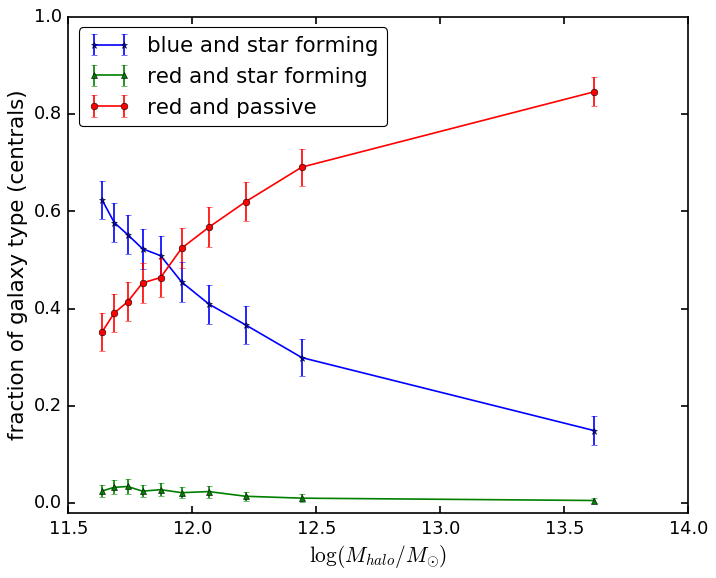

In [12]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

bluact_ind_cent = [x[0] for x in bluact_ind if x[1]==1]
redact_ind_cent = [x[0] for x in redact_ind if x[1]==1]
redpas_ind_cent = [x[0] for x in redpas_ind if x[1]==1]

halo_mass = np.array(halo_mass)
bluact_halo_mass_cent = halo_mass[bluact_ind_cent]
redact_halo_mass_cent = halo_mass[redact_ind_cent]
redpas_halo_mass_cent = halo_mass[redpas_ind_cent]
all_halo_mass_cent = np.concatenate((bluact_halo_mass_cent, redact_halo_mass_cent, redpas_halo_mass_cent))
all_halo_mass_cent = np.sort(all_halo_mass_cent)
i = 0
n = 0
while i <= 0:
    i = all_halo_mass_cent[n]
    n += 1
nonzero_all_halo_mass = all_halo_mass_cent[n-1:]
print np.min(nonzero_all_halo_mass)
    
bin_edges = np.percentile(nonzero_all_halo_mass, np.linspace(0, 100, 11))

plotpts = []
for i in range(len(bin_edges[:-1])):
    plotpts.append(bin_edges[i] + (bin_edges[i+1]-bin_edges[i])/2)

bluact_hist,a_bin = np.histogram(bluact_halo_mass_cent, bin_edges)
redact_hist,b_bin = np.histogram(redact_halo_mass_cent, bin_edges)
redpas_hist,c_bin = np.histogram(redpas_halo_mass_cent, bin_edges)
all_hist = bluact_hist + redact_hist + redpas_hist

c = 0.95
p_bluact_lower = dist.beta.ppf((1-c)/2.,bluact_hist+1,all_hist-bluact_hist+1)
p_bluact_upper = dist.beta.ppf(1-(1-c)/2.,bluact_hist+1,all_hist-bluact_hist+1)

bluact_yerr = p_bluact_lower - p_bluact_upper

p_redact_lower = dist.beta.ppf((1-c)/2.,redact_hist+1,all_hist-redact_hist+1)
p_redact_upper = dist.beta.ppf(1-(1-c)/2.,redact_hist+1,all_hist-redact_hist+1)
redact_yerr = p_redact_lower - p_redact_upper

p_redpas_lower = dist.beta.ppf((1-c)/2.,redpas_hist+1,all_hist-redpas_hist+1)
p_redpas_upper = dist.beta.ppf(1-(1-c)/2.,redpas_hist+1,all_hist-redpas_hist+1)
redpas_yerr = p_redpas_lower - p_redpas_upper


bluact_norm_hist = bluact_hist/all_hist
redact_norm_hist = redact_hist/all_hist
redpas_norm_hist = redpas_hist/all_hist

plt.errorbar(plotpts, bluact_norm_hist, bluact_yerr, c='b', marker='*', label='blue and star forming')
plt.errorbar(plotpts, redact_norm_hist, redact_yerr, c='g', marker='^', label='red and star forming')
plt.errorbar(plotpts, redpas_norm_hist, redpas_yerr, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of galaxy type (centrals)')
plt.xlabel(r'$\log (M_{halo}/M_{\odot})$')
#plt.xlim(11.7, 14.9)
plt.ylim(-0.02,1)

plt.show()

11.61859804
[1020 1020 1019 1020 1015 1021 1016 1010 1022 1034]


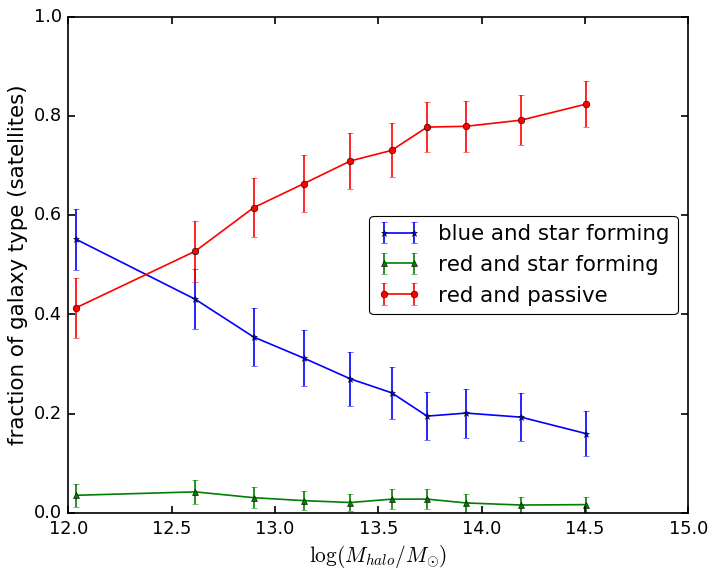

In [13]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

bluact_ind_sat = [x[0] for x in bluact_ind if x[1]==2]
redact_ind_sat = [x[0] for x in redact_ind if x[1]==2]
redpas_ind_sat = [x[0] for x in redpas_ind if x[1]==2]

halo_mass = np.array(halo_mass)
bluact_halo_mass_sat = halo_mass[bluact_ind_sat]
redact_halo_mass_sat = halo_mass[redact_ind_sat]
redpas_halo_mass_sat = halo_mass[redpas_ind_sat]
all_halo_mass_sat = np.concatenate((bluact_halo_mass_sat, redact_halo_mass_sat, redpas_halo_mass_sat))
all_halo_mass_sat = np.sort(all_halo_mass_sat)
i = 0
n = 0
while i <= 0:
    i = all_halo_mass_sat[n]
    n += 1
nonzero_all_halo_mass = all_halo_mass_sat[n-1:]
print np.min(nonzero_all_halo_mass)

bin_edges2 = np.percentile(nonzero_all_halo_mass, np.linspace(0, 100, 11))

bluact_hist2,a_bin2 = np.histogram(bluact_halo_mass_sat, bin_edges2)
redact_hist2,b_bin2 = np.histogram(redact_halo_mass_sat, bin_edges2)
redpas_hist2,c_bin2 = np.histogram(redpas_halo_mass_sat, bin_edges2)
all_hist2 = bluact_hist2 + redact_hist2 + redpas_hist2

plotpts2 = []
for i in range(len(bin_edges2[:-1])):
    plotpts2.append(bin_edges2[i] + (bin_edges2[i+1]-bin_edges2[i])/2)

c = 0.95
p_bluact_lower = dist.beta.ppf((1-c)/2.,bluact_hist2+1,all_hist2-bluact_hist2+1)
p_bluact_upper = dist.beta.ppf(1-(1-c)/2.,bluact_hist2+1,all_hist2-bluact_hist2+1)
bluact_yerr2 = p_bluact_lower - p_bluact_upper

p_redact_lower = dist.beta.ppf((1-c)/2.,redact_hist2+1,all_hist2-redact_hist2+1)
p_redact_upper = dist.beta.ppf(1-(1-c)/2.,redact_hist2+1,all_hist2-redact_hist2+1)
redact_yerr2 = p_redact_lower - p_redact_upper

p_redpas_lower = dist.beta.ppf((1-c)/2.,redpas_hist2+1,all_hist2-redpas_hist2+1)
p_redpas_upper = dist.beta.ppf(1-(1-c)/2.,redpas_hist2+1,all_hist2-redpas_hist2+1)
redpas_yerr2 = p_redpas_lower - p_redpas_upper

print all_hist2

bluact_norm_hist2 = bluact_hist2/all_hist2
redact_norm_hist2 = redact_hist2/all_hist2
redpas_norm_hist2 = redpas_hist2/all_hist2

plt.errorbar(plotpts2, bluact_norm_hist2, bluact_yerr2, c='b', marker='*', label='blue and star forming')
plt.errorbar(plotpts2, redact_norm_hist2, redact_yerr2, c='g', marker='^', label='red and star forming')
plt.errorbar(plotpts2, redpas_norm_hist2, redpas_yerr2, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of galaxy type (satellites)')
plt.xlabel(r'$\log (M_{halo}/M_{\odot})$')
plt.xlim(12, 15)
plt.ylim(0,1)

plt.show()

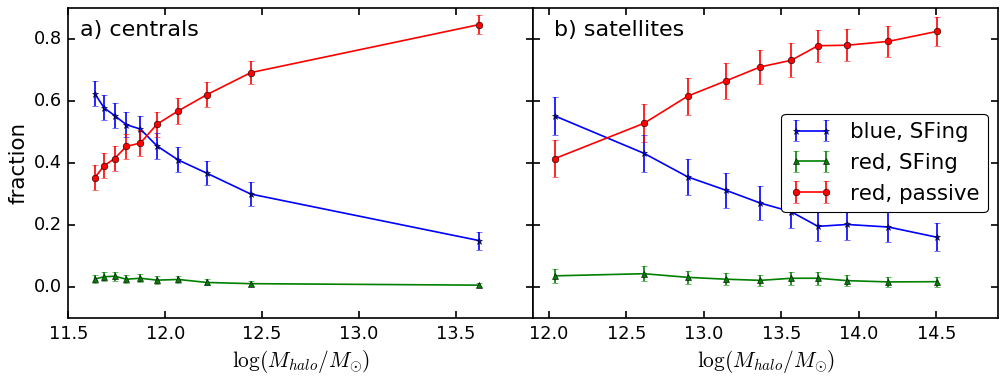

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(15)

ax1.errorbar(plotpts, bluact_norm_hist, bluact_yerr, c='b', marker='*', label='blue and star forming')
ax1.errorbar(plotpts, redact_norm_hist, redact_yerr, c='g', marker='^', label='red and star forming')
ax1.errorbar(plotpts, redpas_norm_hist, redpas_yerr, c='r', marker='o', label='red and passive')
ax1.set_ylabel('fraction')
ax1.set_xlabel(r'$\log (M_{halo}/M_{\odot})$')
ax1.set_xlim(11.5, 13.9)

ax2.errorbar(plotpts2, bluact_norm_hist2, bluact_yerr2, c='b', marker='*', label='blue, SFing')
ax2.errorbar(plotpts2, redact_norm_hist2, redact_yerr2, c='g', marker='^', label='red, SFing')
ax2.errorbar(plotpts2, redpas_norm_hist2, redpas_yerr2, c='r', marker='o', label='red, passive')
ax2.set_xlabel(r'$\log (M_{halo}/M_{\odot})$')
ax2.set_xlim(11.9, 14.9)

plt.legend()
f.subplots_adjust(wspace=0)

f.text(0.135, 0.83,'a) centrals',fontsize=20)
f.text(0.53, 0.83,'b) satellites',fontsize=20)
plt.savefig('../plots/ssfr_hist_centsat.png',dpi=300)

11.61599804


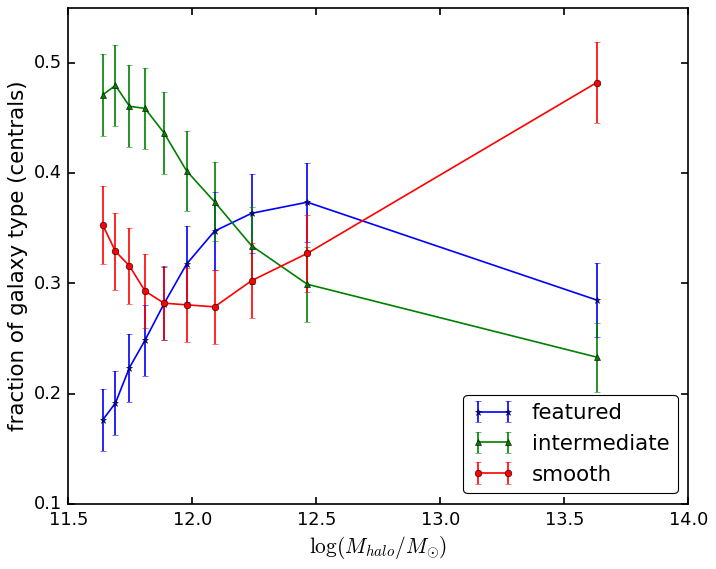

In [39]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

spiral_ind_cent = [x[0] for x in spiral_ind if x[1]==1]
int_ind_cent = [x[0] for x in int_ind if x[1]==1]
smooth_ind_cent = [x[0] for x in smooth_ind if x[1]==1]

halo_mass = np.array(halo_mass)
spiral_halo_mass_cent = halo_mass[spiral_ind_cent]
int_halo_mass_cent = halo_mass[int_ind_cent]
smooth_halo_mass_cent = halo_mass[smooth_ind_cent]
all_halo_mass_cent_mo = np.concatenate((spiral_halo_mass_cent, int_halo_mass_cent, smooth_halo_mass_cent))
all_halo_mass_cent_mo = np.sort(all_halo_mass_cent_mo)
i = 0
n = 0
while i <= 0:
    i = all_halo_mass_cent_mo[n]
    n += 1
nonzero_all_halo_mass_mo = all_halo_mass_cent_mo[n-1:]
print np.min(nonzero_all_halo_mass_mo)

bin_edges_mo = np.percentile(nonzero_all_halo_mass_mo, np.linspace(0, 100, 11))

spiral_hist,a = np.histogram(spiral_halo_mass_cent, bin_edges_mo)
int_hist,b = np.histogram(int_halo_mass_cent, bin_edges_mo)
smooth_hist,c = np.histogram(smooth_halo_mass_cent, bin_edges_mo)
all_hist = spiral_hist + smooth_hist + int_hist

c = 0.95
p_spiral_lower = dist.beta.ppf((1-c)/2.,spiral_hist+1,all_hist-spiral_hist+1)
p_spiral_upper = dist.beta.ppf(1-(1-c)/2.,spiral_hist+1,all_hist-spiral_hist+1)
spiral_yerr = p_spiral_upper - p_spiral_lower

p_int_lower = dist.beta.ppf((1-c)/2.,int_hist+1,all_hist-int_hist+1)
p_int_upper = dist.beta.ppf(1-(1-c)/2.,int_hist+1,all_hist-int_hist+1)
int_yerr = p_int_upper - p_int_lower

p_smooth_lower = dist.beta.ppf((1-c)/2.,smooth_hist+1,all_hist-smooth_hist+1)
p_smooth_upper = dist.beta.ppf(1-(1-c)/2.,smooth_hist+1,all_hist-smooth_hist+1)
smooth_yerr = p_smooth_upper - p_smooth_lower

spiral_norm_hist_cent = spiral_hist/all_hist
int_norm_hist_cent = int_hist/all_hist
smooth_norm_hist_cent = smooth_hist/all_hist

plotpts_mo = []
for i in range(len(bin_edges_mo[:-1])):
    plotpts_mo.append(bin_edges_mo[i] + (bin_edges_mo[i+1]-bin_edges_mo[i])/2)

plt.errorbar(plotpts_mo, spiral_norm_hist_cent, spiral_yerr, c='b', marker='*', label='featured')
plt.errorbar(plotpts_mo, int_norm_hist_cent, int_yerr, c='g', marker='^', label='intermediate')
plt.errorbar(plotpts_mo, smooth_norm_hist_cent, smooth_yerr, c='r', marker='o', label='smooth')
#plt.errorbar(bin_edges[1:], spiral_norm_hist_cent, spiral_yerr, c='b', marker='*', label='featured')
#plt.errorbar(bin_edges[1:], int_norm_hist_cent, int_yerr, c='g', marker='^', label='intermediate')
#plt.errorbar(bin_edges[1:], smooth_norm_hist_cent, smooth_yerr, c='r', marker='o', label='smooth')
plt.legend()
plt.ylabel('fraction of galaxy type (centrals)')
plt.xlabel(r'$\log (M_{halo}/M_{\odot})$')
#plt.xlim(12, 15)
#plt.ylim(0,1)

plt.show()

11.61859804


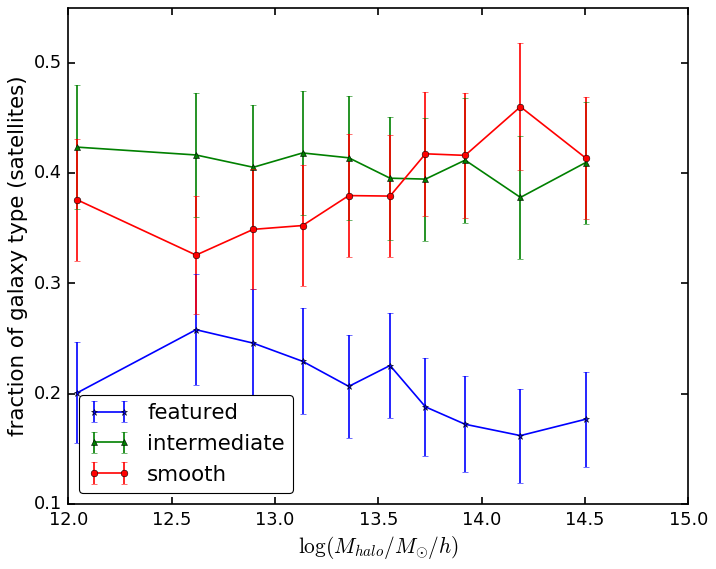

In [40]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

spiral_ind_sat = [x[0] for x in spiral_ind if x[1]==2]
int_ind_sat = [x[0] for x in int_ind if x[1]==2]
smooth_ind_sat = [x[0] for x in smooth_ind if x[1]==2]

halo_mass = np.array(halo_mass)
spiral_halo_mass_sat = halo_mass[spiral_ind_sat]
int_halo_mass_sat = halo_mass[int_ind_sat]
smooth_halo_mass_sat = halo_mass[smooth_ind_sat]
all_halo_mass_cent_mo2 = np.concatenate((spiral_halo_mass_sat, int_halo_mass_sat, smooth_halo_mass_sat))
all_halo_mass_cent_mo2 = np.sort(all_halo_mass_cent_mo2)
i = 0
n = 0
while i <= 0:
    i = all_halo_mass_cent_mo2[n]
    n += 1
nonzero_all_halo_mass_mo2 = all_halo_mass_cent_mo2[n-1:]
print np.min(nonzero_all_halo_mass_mo2)

bin_edges_mo2 = np.percentile(nonzero_all_halo_mass_mo2, np.linspace(0, 100, 11))

spiral_hist,a = np.histogram(spiral_halo_mass_sat, bin_edges_mo2)
int_hist,b = np.histogram(int_halo_mass_sat, bin_edges_mo2)
smooth_hist,bin_edges = np.histogram(smooth_halo_mass_sat, bin_edges_mo2)
all_hist = spiral_hist + smooth_hist + int_hist

c = 0.95
p_spiral_lower = dist.beta.ppf((1-c)/2.,spiral_hist+1,all_hist-spiral_hist+1)
p_spiral_upper = dist.beta.ppf(1-(1-c)/2.,spiral_hist+1,all_hist-spiral_hist+1)
spiral_yerr2 = p_spiral_upper - p_spiral_lower

p_int_lower = dist.beta.ppf((1-c)/2.,int_hist+1,all_hist-int_hist+1)
p_int_upper = dist.beta.ppf(1-(1-c)/2.,int_hist+1,all_hist-int_hist+1)
int_yerr2 = p_int_upper - p_int_lower

p_smooth_lower = dist.beta.ppf((1-c)/2.,smooth_hist+1,all_hist-smooth_hist+1)
p_smooth_upper = dist.beta.ppf(1-(1-c)/2.,smooth_hist+1,all_hist-smooth_hist+1)
smooth_yerr2 = p_smooth_upper - p_smooth_lower


spiral_norm_hist = spiral_hist/all_hist
int_norm_hist = int_hist/all_hist
smooth_norm_hist = smooth_hist/all_hist

plotpts_mo2 = []
for i in range(len(bin_edges_mo2[:-1])):
    plotpts_mo2.append(bin_edges_mo2[i] + (bin_edges_mo2[i+1]-bin_edges_mo2[i])/2)

plt.errorbar(plotpts_mo2, spiral_norm_hist, spiral_yerr2, c='b', marker='*', label='featured')
plt.errorbar(plotpts_mo2, int_norm_hist, int_yerr2, c='g', marker='^', label='intermediate')
plt.errorbar(plotpts_mo2, smooth_norm_hist, smooth_yerr2, c='r', marker='o', label='smooth')
plt.legend()
plt.ylabel('fraction of galaxy type (satellites)')
plt.xlabel(r'$\log (M_{halo}/M_{\odot}/h)$')
#plt.xlim(11, 15)
#plt.ylim(0,1)

plt.show()

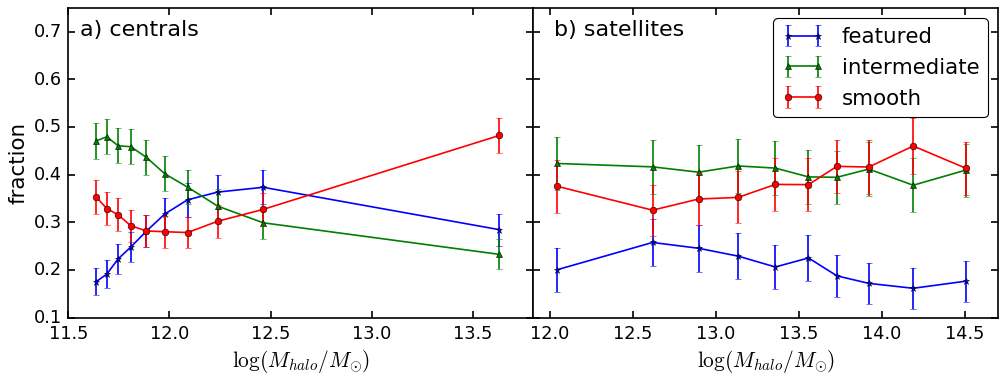

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(15)

ax1.errorbar(plotpts_mo, spiral_norm_hist_cent, spiral_yerr, c='b', marker='*', label='featured')
ax1.errorbar(plotpts_mo, int_norm_hist_cent, int_yerr, c='g', marker='^', label='intermediate')
ax1.errorbar(plotpts_mo, smooth_norm_hist_cent, smooth_yerr, c='r', marker='o', label='smooth')
ax1.set_ylabel('fraction')
ax1.set_xlabel(r'$\log (M_{halo}/M_{\odot})$')
#plt.legend()
ax1.set_xlim(11.5, 13.8)

ax2.errorbar(plotpts_mo2, spiral_norm_hist, spiral_yerr2, c='b', marker='*', label='featured')
ax2.errorbar(plotpts_mo2, int_norm_hist, int_yerr2, c='g', marker='^', label='intermediate')
ax2.errorbar(plotpts_mo2, smooth_norm_hist, smooth_yerr2, c='r', marker='o', label='smooth')
ax2.set_xlabel(r'$\log (M_{halo}/M_{\odot})$')
ax2.set_xlim(11.9, 14.7)

f.subplots_adjust(wspace=0)
plt.legend(loc='upper right')
plt.ylim(0.1,0.75)
f.text(0.135, 0.83,'a) centrals',fontsize=20)
f.text(0.53, 0.83,'b) satellites',fontsize=20)
plt.savefig('../plots/morph_hist_centsat.png',dpi=300)

In [16]:
fig = plt.figure(figsize=(10,8))
bluact_mr_sat = [x[0] for x in bluact_mr if x[1]==2]
redact_mr_sat = [x[0] for x in redact_mr if x[1]==2]
redpas_mr_sat = [x[0] for x in redpas_mr if x[1]==2]
all_mr_sat = np.concatenate((bluact_mr_sat,redact_mr_sat,redpas_mr_sat))
plt.style.use(mpl_style.style1)

bluact_mr_hist,a = np.histogram(bluact_mr_sat, bins=50)
redact_mr_hist,b = np.histogram(redact_mr_sat, bins=50)
redpas_mr_hist,bin_edges = np.histogram(redpas_mr_sat, bins=50)
all_mr_hist = bluact_mr_hist + redact_mr_hist + redpas_mr_hist

bluact_mr_hist = bluact_mr_hist/all_mr_hist
redact_mr_hist = redact_mr_hist/all_mr_hist
redpas_mr_hist = redpas_mr_hist/all_mr_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_mr_hist, c='b', marker='*', label='blue and star forming')
plt.plot(bin_edges_adj, redact_mr_hist, c='g', marker='^', label='red and star forming')
plt.plot(bin_edges_adj, redpas_mr_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of satellites')
plt.xlabel(r'$M_r - 5\log(h)$')
#plt.xlim(-22, -15)
plt.ylim(0,1)

plt.close()

p value of KS test on high star-forming centrals and low star-forming centrals: 2.66155937174e-13


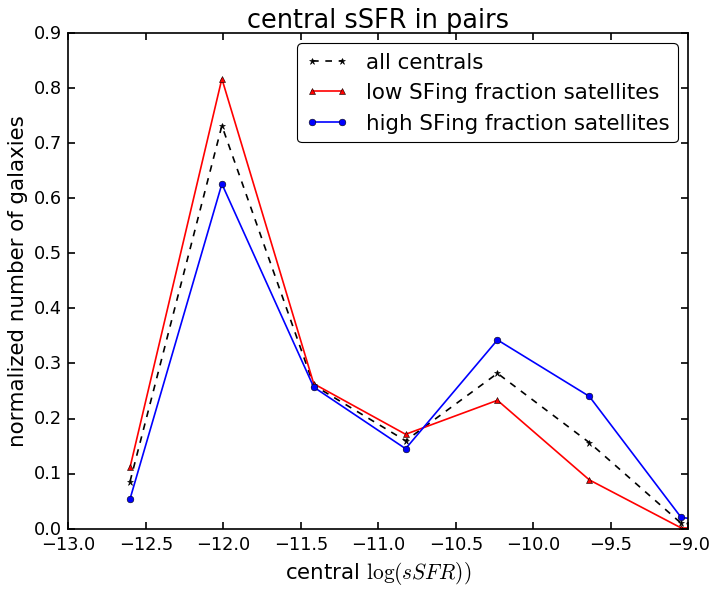

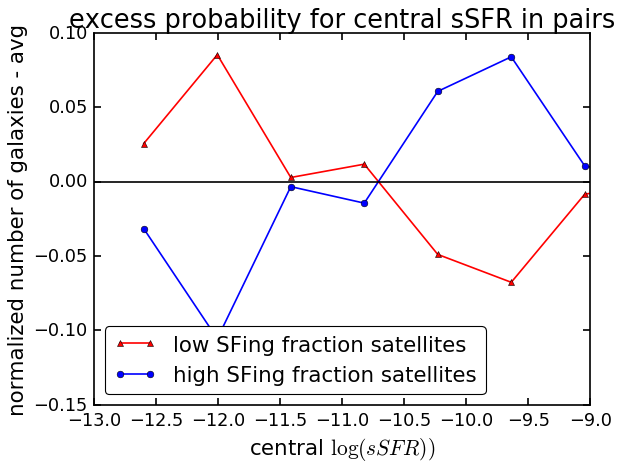

[ 0.1318955]
[ 0.15889613]


In [21]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)


cent_ssfr_hist_SG, all_bins_SG = np.histogram(np.concatenate((SG_cent_ssfr_pas_sat, SG_cent_ssfr_act_sat)), density=True)
cent_ssfr_pas_sat_hist_SG, pas_bins_SG= np.histogram(SG_cent_ssfr_pas_sat, density=True, bins=all_bins_SG)
cent_ssfr_act_sat_hist_SG, act_bins_SG = np.histogram(SG_cent_ssfr_act_sat, density=True, bins=all_bins_SG)

D, p_val = ks_2samp(SG_cent_ssfr_pas_sat, SG_cent_ssfr_act_sat)
print('p value of KS test on high star-forming centrals and low star-forming centrals: '+str(p_val))

all_binsize_SG = all_bins_SG[2] - all_bins_SG[1]
pas_binsize_SG = pas_bins_SG[2] - pas_bins_SG[1]
act_binsize_SG = act_bins_SG[2] - act_bins_SG[1]

plt.plot(all_bins_SG[1:] - all_binsize_SG/2, cent_ssfr_hist_SG, c='k', marker='*', label='all centrals',linestyle='--')
plt.plot(pas_bins_SG[1:] - pas_binsize_SG/2, cent_ssfr_pas_sat_hist_SG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_SG[1:] - act_binsize_SG/2, cent_ssfr_act_sat_hist_SG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in pairs')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.show()

plt.plot(pas_bins_SG[1:] - pas_binsize_SG/2, cent_ssfr_pas_sat_hist_SG - cent_ssfr_hist_SG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_SG[1:] - act_binsize_SG/2, cent_ssfr_act_sat_hist_SG - cent_ssfr_hist_SG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.axhline(0, c='k')
plt.title('excess probability for central sSFR in pairs')
plt.ylabel('normalized number of galaxies - avg')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.show()

bins = all_bins_SG[1:] - all_binsize_SG/2
low_sfr_ind =[np.where(bins < -11)]
low_sfr_bins = bins[low_sfr_ind]
low_sfr_act = cent_ssfr_act_sat_hist_SG[low_sfr_ind]
low_sfr_pas = cent_ssfr_pas_sat_hist_SG[low_sfr_ind]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_ind =[np.where(bins >= -11)]
high_sfr_bins = bins[high_sfr_ind]
high_sfr_act= cent_ssfr_act_sat_hist_SG[high_sfr_ind]
high_sfr_pas = cent_ssfr_pas_sat_hist_SG[high_sfr_ind]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

p value of KS test on high star-forming centrals and low star-forming centrals: 3.22822802002e-05


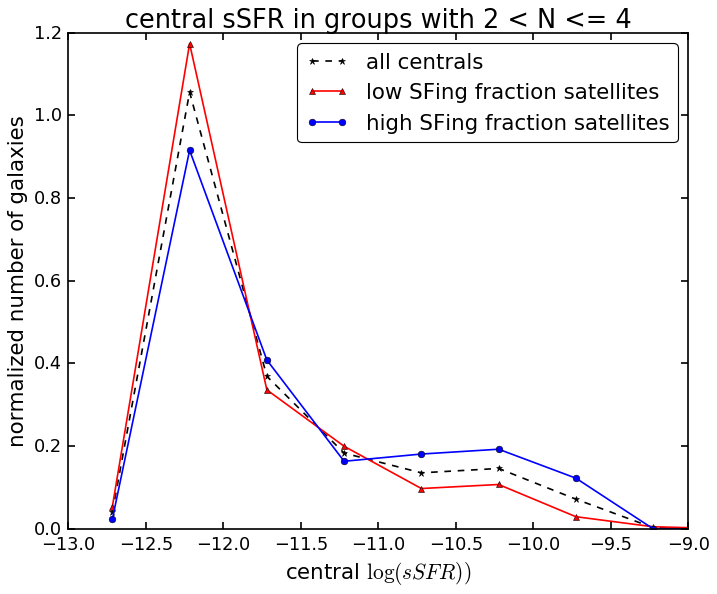

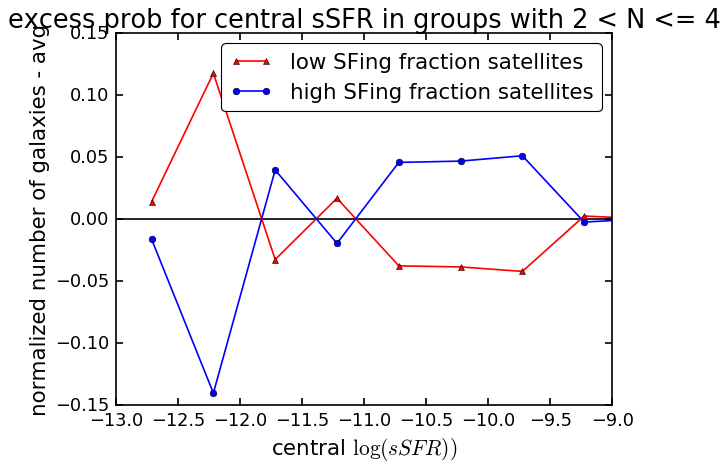

('Low SF central excess probability', array([ 0.10913863]))
('high SF central excess probability', array([ 0.1061611]))


In [22]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_ssfr_hist_LG, all_bins_LG = np.histogram(np.concatenate((LG_cent_ssfr_pas_sat, LG_cent_ssfr_act_sat)), density=True)
cent_ssfr_pas_sat_hist_LG, pas_bins_LG = np.histogram(LG_cent_ssfr_pas_sat, density=True, bins=all_bins_LG)
cent_ssfr_act_sat_hist_LG, act_bins_LG = np.histogram(LG_cent_ssfr_act_sat, density=True, bins = all_bins_LG)

D, p_val = ks_2samp(LG_cent_ssfr_pas_sat, LG_cent_ssfr_act_sat)
print('p value of KS test on high star-forming centrals and low star-forming centrals: '+str(p_val))

all_binsize_LG = all_bins_LG[2] - all_bins_LG[1]
pas_binsize_LG = pas_bins_LG[2] - pas_bins_LG[1]
act_binsize_LG = act_bins_LG[2] - act_bins_LG[1]

plt.plot(all_bins_LG[1:] - all_binsize_LG/2, cent_ssfr_hist_LG, c='k', marker='*', label='all centrals',linestyle='--')
plt.plot(pas_bins_LG[1:] - pas_binsize_LG/2, cent_ssfr_pas_sat_hist_LG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_LG[1:] - act_binsize_LG/2, cent_ssfr_act_sat_hist_LG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups with 2 < N <= 4')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.show()

plt.axhline(0, c='k')
plt.plot(pas_bins_LG[1:] - pas_binsize_LG/2, cent_ssfr_pas_sat_hist_LG - cent_ssfr_hist_LG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_LG[1:] - act_binsize_LG/2, cent_ssfr_act_sat_hist_LG - cent_ssfr_hist_LG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob for central sSFR in groups with 2 < N <= 4')
plt.ylabel('normalized number of galaxies - avg')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.show()

bins = all_bins_LG[1:] - all_binsize_LG/2
low_sfr_ind =[np.where(bins < -11)]
low_sfr_bins = bins[low_sfr_ind]
low_sfr_act = cent_ssfr_act_sat_hist_LG[low_sfr_ind]
low_sfr_pas = cent_ssfr_pas_sat_hist_LG[low_sfr_ind]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_ind =[np.where(bins >= -11)]
high_sfr_bins = bins[high_sfr_ind]
high_sfr_act= cent_ssfr_act_sat_hist_LG[high_sfr_ind]
high_sfr_pas = cent_ssfr_pas_sat_hist_LG[high_sfr_ind]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

p value of KS test on high star-forming centrals and low star-forming centrals: 0.000105441928193
number of groups with passive, active satellites
(441, 80)


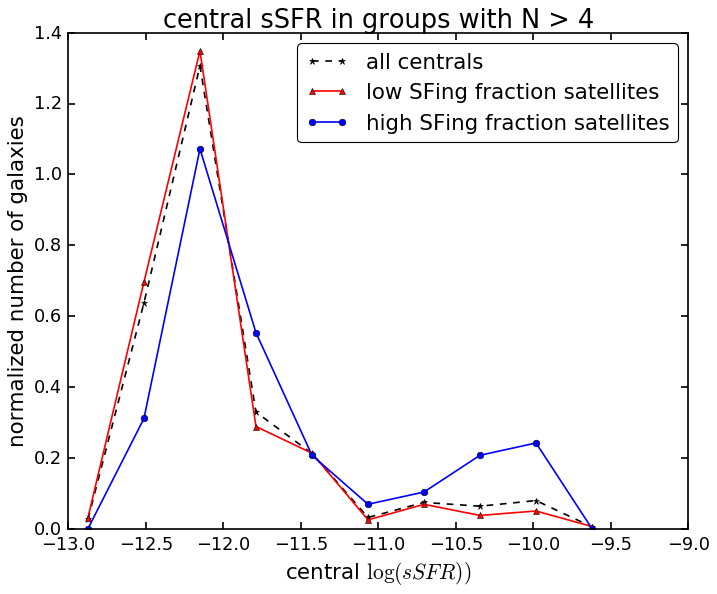

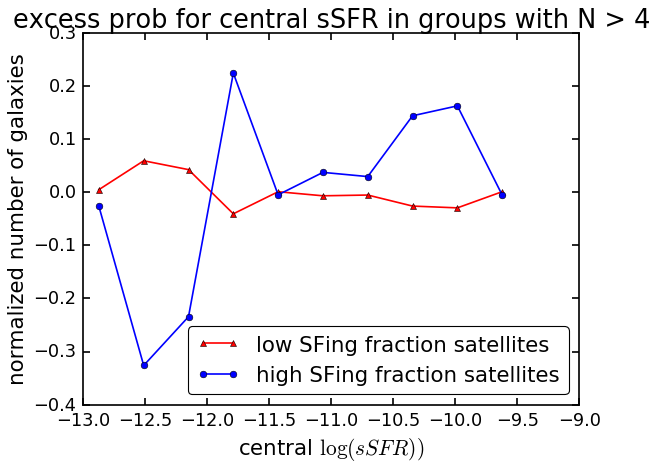

('Low SF central excess probability', array([ 0.143339]))
('high SF central excess probability', array([ 0.13589853]))


In [23]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_ssfr_hist_VLG, all_bins_VLG = np.histogram(np.concatenate((VLG_cent_ssfr_pas_sat, VLG_cent_ssfr_act_sat)), density=True)
cent_ssfr_pas_sat_hist_VLG, pas_bins_VLG = np.histogram(VLG_cent_ssfr_pas_sat, density=True, bins=all_bins_VLG)
cent_ssfr_act_sat_hist_VLG, act_bins_VLG = np.histogram(VLG_cent_ssfr_act_sat, density=True, bins=all_bins_VLG)

D, p_val = ks_2samp(VLG_cent_ssfr_pas_sat, VLG_cent_ssfr_act_sat)
print('p value of KS test on high star-forming centrals and low star-forming centrals: '+str(p_val))
print('number of groups with passive, active satellites')
print(len(VLG_cent_ssfr_pas_sat), len(VLG_cent_ssfr_act_sat))
all_binsize_VLG = all_bins_VLG[2] - all_bins_VLG[1]
pas_binsize_VLG = pas_bins_VLG[2] - pas_bins_VLG[1]
act_binsize_VLG = act_bins_VLG[2] - act_bins_VLG[1]

plt.plot(all_bins_VLG[1:] - all_binsize_VLG/2, cent_ssfr_hist_VLG, c='k', marker='*', label='all centrals',linestyle='--')
plt.plot(pas_bins_VLG[1:] - pas_binsize_VLG/2, cent_ssfr_pas_sat_hist_VLG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_VLG[1:] - act_binsize_VLG/2, cent_ssfr_act_sat_hist_VLG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups with N > 4')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.show()

plt.plot(pas_bins_VLG[1:] - pas_binsize_VLG/2, cent_ssfr_pas_sat_hist_VLG - cent_ssfr_hist_VLG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_VLG[1:] - act_binsize_VLG/2, cent_ssfr_act_sat_hist_VLG - cent_ssfr_hist_VLG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob for central sSFR in groups with N > 4')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.show()

bins = all_bins_VLG[1:] - all_binsize_VLG/2
low_sfr_ind =[np.where(bins < -11)]
low_sfr_bins = bins[low_sfr_ind]
low_sfr_act = cent_ssfr_act_sat_hist_VLG[low_sfr_ind]
low_sfr_pas = cent_ssfr_pas_sat_hist_VLG[low_sfr_ind]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_ind =[np.where(bins >= -11)]
high_sfr_bins = bins[high_sfr_ind]
high_sfr_act= cent_ssfr_act_sat_hist_VLG[high_sfr_ind]
high_sfr_pas = cent_ssfr_pas_sat_hist_VLG[high_sfr_ind]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

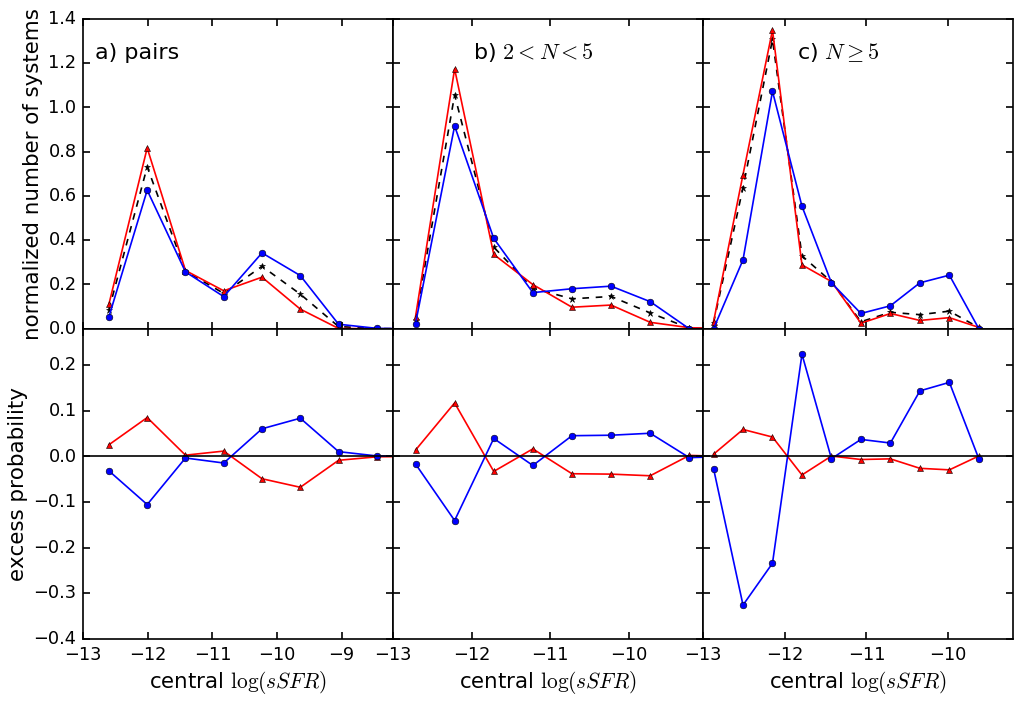

In [46]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
f.set_figheight(10)
f.set_figwidth(15)

ax1.plot(all_bins_SG[1:] - all_binsize_SG/2, cent_ssfr_hist_SG, c='k', marker='*', label='all centrals',linestyle='--')
ax1.plot(pas_bins_SG[1:] - pas_binsize_SG/2, cent_ssfr_pas_sat_hist_SG, c='r', marker='^', label='low SFing fraction satellites')
ax1.plot(act_bins_SG[1:] - act_binsize_SG/2, cent_ssfr_act_sat_hist_SG, c='b', marker='o', label='high SFing fraction satellites')
ax1.set_ylabel('normalized number of systems')
#ax1.set_xlabel('central '+r'$\log(sSFR)$')
#ax1.set_ylim(0, 1.4)
ax1.set_xlim(-13, -8.2)
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, 1))

ax2.plot(all_bins_LG[1:] - all_binsize_LG/2, cent_ssfr_hist_LG, c='k', marker='*', label='all',linestyle='--')
ax2.plot(pas_bins_LG[1:] - pas_binsize_LG/2, cent_ssfr_pas_sat_hist_LG, c='r', marker='^', label='low SF')
ax2.plot(act_bins_LG[1:] - act_binsize_LG/2, cent_ssfr_act_sat_hist_LG, c='b', marker='o', label='high SF')
ax2.set_xlim(-13, -9.05)
#ax2.set_ylim(0, 1.4)
#ax2.set_xlabel('central '+r'$\log (sSFR))$')
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 1))

ax3.plot(all_bins_VLG[1:] - all_binsize_VLG/2, cent_ssfr_hist_VLG, c='k', marker='*', label='all',linestyle='--')
ax3.plot(pas_bins_VLG[1:] - pas_binsize_VLG/2, cent_ssfr_pas_sat_hist_VLG, c='r', marker='^', label='low SF')
ax3.plot(act_bins_VLG[1:] - act_binsize_VLG/2, cent_ssfr_act_sat_hist_VLG, c='b', marker='o', label='high SF')
ax3.set_xlim(-13, -9.2)
#ax3.set_ylim(0, 1.4)
plt.legend()
#ax3.set_xlabel('central '+r'$\log (sSFR))$')
start, end = ax3.get_xlim()
ax3.xaxis.set_ticks(np.arange(start, end, 1))

ax4.plot(pas_bins_SG[1:] - pas_binsize_SG/2, cent_ssfr_pas_sat_hist_SG - cent_ssfr_hist_SG, c='r', marker='^', label='low SFing fraction satellites')
ax4.plot(act_bins_SG[1:] - act_binsize_SG/2, cent_ssfr_act_sat_hist_SG - cent_ssfr_hist_SG, c='b', marker='o', label='high SFing fraction satellites')
ax4.set_ylabel('excess probability')
ax4.set_xlabel('central '+r'$\log(sSFR)$')
ax4.axhline(0, c='k')
ax4.set_ylim(-0.4, 0.28)

ax5.plot(pas_bins_LG[1:] - pas_binsize_LG/2, cent_ssfr_pas_sat_hist_LG - cent_ssfr_hist_LG, c='r', marker='^', label='low SFing fraction satellites')
ax5.plot(act_bins_LG[1:] - act_binsize_LG/2, cent_ssfr_act_sat_hist_LG - cent_ssfr_hist_LG, c='b', marker='o', label='high SFing fraction satellites')
ax5.set_xlabel('central '+r'$\log(sSFR)$')
ax5.axhline(0, c='k')
#ax5.set_ylim(-0.3, 0.3)

ax6.plot(pas_bins_VLG[1:] - pas_binsize_VLG/2, cent_ssfr_pas_sat_hist_VLG - cent_ssfr_hist_VLG, c='r', marker='^', label='low SFing fraction satellites')
ax6.plot(act_bins_VLG[1:] - act_binsize_VLG/2, cent_ssfr_act_sat_hist_VLG - cent_ssfr_hist_VLG, c='b', marker='o', label='high SFing fraction satellites')
ax6.set_xlabel('central '+r'$\log(sSFR)$')
ax6.axhline(0, c='k')
#ax6.set_ylim(-0.3, 0.3)

f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)

f.text(0.135, 0.85,'a) pairs',fontsize=20)
f.text(0.45, 0.85,r'b) $2 < N < 5$',fontsize=20)
f.text(0.72, 0.85,r'c) $N \geq 5$',fontsize=20)
plt.savefig('../plots/ssfr_hist.png',dpi=300)

p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: 6.50670554887e-10


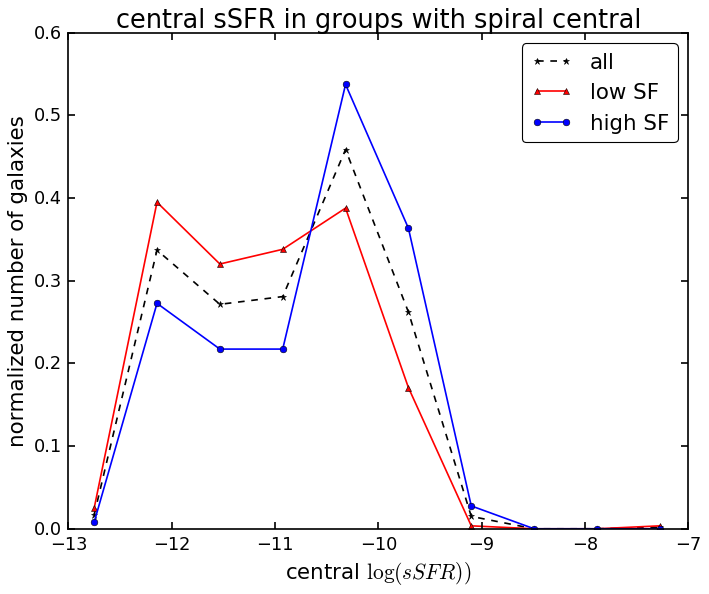

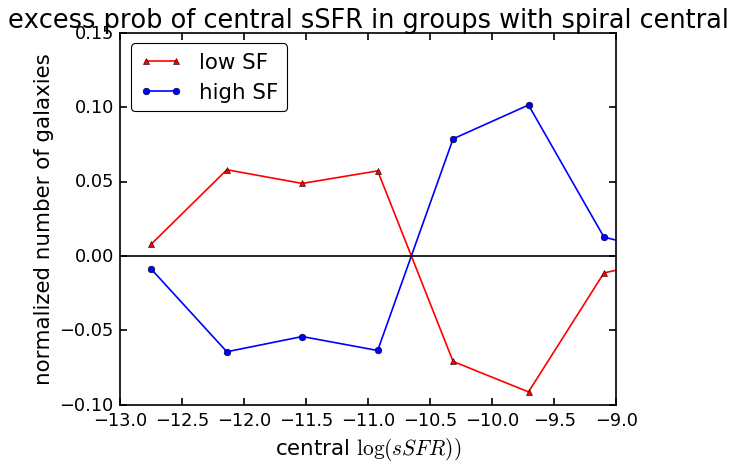

('Low SF central excess probability', array([ 0.1108631]))
('high SF central excess probability', array([ 0.18512217]))


In [48]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_spiral_ssfr_hist, all_bins = np.histogram(np.concatenate((AG_spiral_cent_ssfr_pas_sat, AG_spiral_cent_ssfr_act_sat)), density=True)
cent_spiral_ssfr_pas_sat_hist,pas_bins = np.histogram(AG_spiral_cent_ssfr_pas_sat, density=True, bins=all_bins)
cent_spiral_ssfr_act_sat_hist,act_bins = np.histogram(AG_spiral_cent_ssfr_act_sat, density=True, bins=all_bins)

all_binsize = all_bins[2] - all_bins[1]
pas_binsize = pas_bins[2] - pas_bins[1]
act_binsize = act_bins[2] - act_bins[1]

D, p_val = ks_2samp(AG_spiral_cent_ssfr_pas_sat, AG_spiral_cent_ssfr_act_sat)
print('p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: '+str(p_val))

plt.plot(all_bins[1:] - all_binsize/2, cent_spiral_ssfr_hist, c='k', marker='*', label='all',linestyle='--')
plt.plot(pas_bins[1:] - pas_binsize/2, cent_spiral_ssfr_pas_sat_hist, c='r', marker='^', label='low SF')
plt.plot(act_bins[1:] - act_binsize/2, cent_spiral_ssfr_act_sat_hist, c='b', marker='o', label='high SF')
plt.legend()
plt.title('central sSFR in groups with spiral central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(12.5, 15)
plt.show()

plt.plot(pas_bins[1:] - pas_binsize/2, cent_spiral_ssfr_pas_sat_hist - cent_spiral_ssfr_hist, c='r', marker='^', label='low SF')
plt.plot(act_bins[1:] - act_binsize/2, cent_spiral_ssfr_act_sat_hist - cent_spiral_ssfr_hist, c='b', marker='o', label='high SF')
plt.legend()
plt.title('excess prob of central sSFR in groups with spiral central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.xlim(-13, -9)
plt.axhline(0,c='k')
plt.show()

bins = all_bins[1:] - all_binsize/2
low_sfr_ind =[np.where(bins < -11)]
low_sfr_bins = bins[low_sfr_ind]
low_sfr_act = cent_spiral_ssfr_act_sat_hist[low_sfr_ind]
low_sfr_pas = cent_spiral_ssfr_pas_sat_hist[low_sfr_ind]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_ind =[np.where(bins >= -11)]
high_sfr_bins = bins[high_sfr_ind]
high_sfr_act= cent_spiral_ssfr_act_sat_hist[high_sfr_ind]
high_sfr_pas = cent_spiral_ssfr_pas_sat_hist[high_sfr_ind]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: 1.5352459156e-13


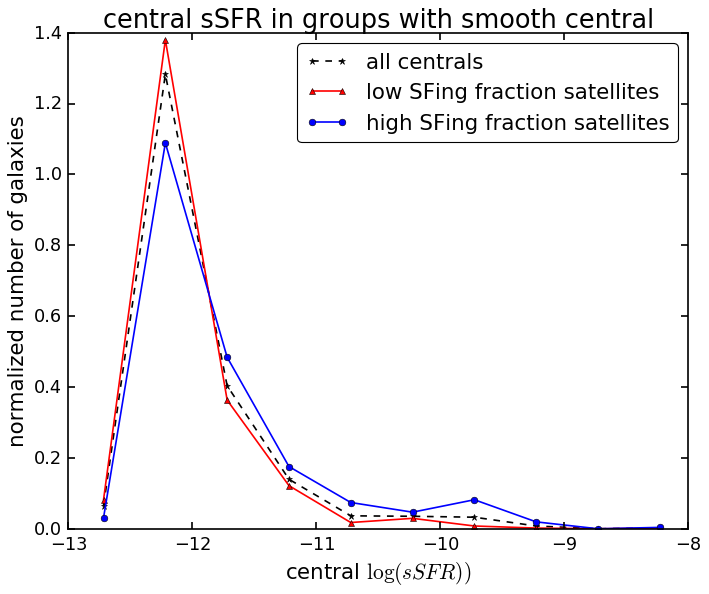

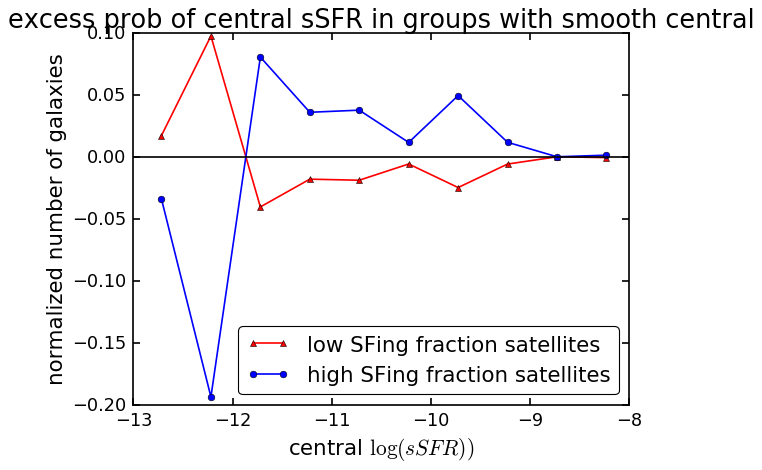

('Low SF central excess probability', array([ 0.08416205]))
('high SF central excess probability', array([ 0.06892337]))


In [50]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_smooth_ssfr_hist, all_bins2 = np.histogram(np.concatenate((AG_smooth_cent_ssfr_pas_sat, AG_smooth_cent_ssfr_act_sat)), density=True)
cent_smooth_ssfr_pas_sat_hist, pas_bins2 = np.histogram(AG_smooth_cent_ssfr_pas_sat, bins=all_bins2, density=True)
cent_smooth_ssfr_act_sat_hist, act_bins2 = np.histogram(AG_smooth_cent_ssfr_act_sat, bins=all_bins2, density=True)

all_binsize2 = all_bins2[2] - all_bins2[1]
pas_binsize2 = pas_bins2[2] - pas_bins2[1]
act_binsize2 = act_bins2[2] - act_bins2[1]

D, p_val = ks_2samp(AG_smooth_cent_ssfr_pas_sat, AG_smooth_cent_ssfr_act_sat)
print('p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: '+str(p_val))

plt.plot(all_bins2[1:] - all_binsize2/2, cent_smooth_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
plt.plot(pas_bins2[1:] - pas_binsize2/2, cent_smooth_ssfr_pas_sat_hist, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins2[1:] - act_binsize2/2, cent_smooth_ssfr_act_sat_hist, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups with smooth central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(12.5, 15)
plt.show()

plt.plot(pas_bins2[1:] - pas_binsize2/2, cent_smooth_ssfr_pas_sat_hist - cent_smooth_ssfr_hist, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins2[1:] - act_binsize2/2, cent_smooth_ssfr_act_sat_hist - cent_smooth_ssfr_hist, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob of central sSFR in groups with smooth central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.axhline(0,c='k')
plt.show()

bins = all_bins2[1:] - all_binsize2/2
low_sfr_ind =[np.where(bins < -11)]
low_sfr_bins = bins[low_sfr_ind]
low_sfr_act = cent_smooth_ssfr_act_sat_hist[low_sfr_ind]
low_sfr_pas = cent_smooth_ssfr_pas_sat_hist[low_sfr_ind]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_ind =[np.where(bins >= -11)]
high_sfr_bins = bins[high_sfr_ind]
high_sfr_act= cent_smooth_ssfr_act_sat_hist[high_sfr_ind]
high_sfr_pas = cent_smooth_ssfr_pas_sat_hist[high_sfr_ind]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

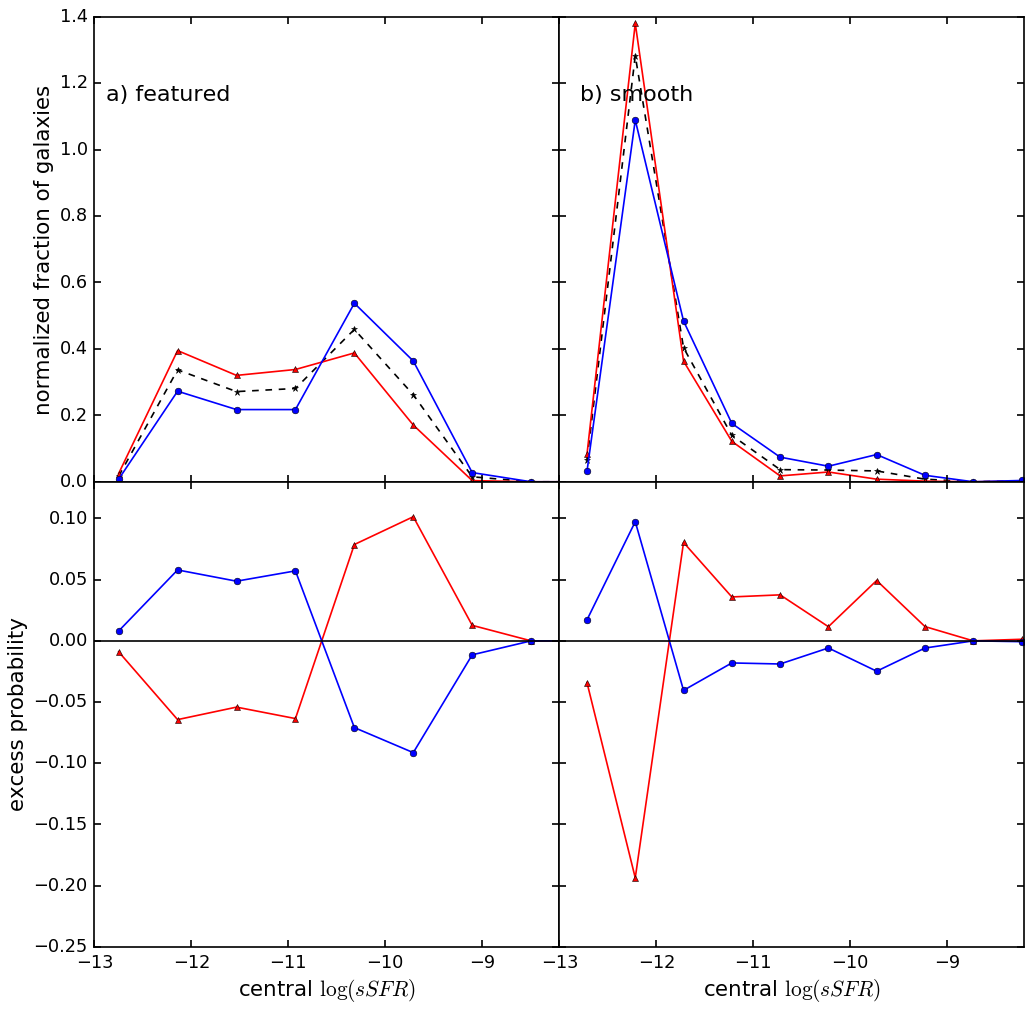

In [55]:
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey='row', sharex='col')
f.set_figheight(15)
f.set_figwidth(15)

ax1.plot(all_bins[1:] - all_binsize/2, cent_spiral_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
ax1.plot(pas_bins[1:] - pas_binsize/2, cent_spiral_ssfr_pas_sat_hist, c='r', marker='^', label='low SFing fraction satellites')
ax1.plot(act_bins[1:] - act_binsize/2, cent_spiral_ssfr_act_sat_hist, c='b', marker='o', label='high SFing fraction satellites')
#ax1.legend()
ax1.set_ylabel('normalized fraction of galaxies')
#ax1.set_xlabel('central '+r'$\log(sSFR)$')
#ax1.set_ylim(0, 1.5)
ax1.set_xlim(-13, -8.2)

ax2.plot(all_bins2[1:] - all_binsize2/2, cent_smooth_ssfr_hist, c='k', marker='*', label='all',linestyle='--')
ax2.plot(pas_bins2[1:] - pas_binsize2/2, cent_smooth_ssfr_pas_sat_hist, c='r', marker='^', label='low SF')
ax2.plot(act_bins2[1:] - act_binsize2/2, cent_smooth_ssfr_act_sat_hist, c='b', marker='o', label='high SF')
#ax2.set_ylabel('fraction')
ax2.set_xlim(-13, -8.2)
plt.legend()
#ax2.set_xlabel('central '+r'$\log (sSFR))$')

ax3.plot(pas_bins[1:] - all_binsize/2, cent_spiral_ssfr_act_sat_hist - cent_spiral_ssfr_hist, c='r', marker='^', label='low SFing fraction satellites')
ax3.plot(act_bins[1:] - all_binsize/2, cent_spiral_ssfr_pas_sat_hist - cent_spiral_ssfr_hist, c='b', marker='o', label='high SFing fraction satellites')
ax3.set_ylabel('excess probability')
ax3.set_xlabel('central '+r'$\log(sSFR)$')
ax3.axhline(0, c='k')
ax3.set_ylim(-0.25, 0.13)

ax4.plot(pas_bins2[1:] - all_binsize2/2, cent_smooth_ssfr_act_sat_hist - cent_smooth_ssfr_hist, c='r', marker='^', label='low SFing fraction satellites')
ax4.plot(act_bins2[1:] - all_binsize2/2, cent_smooth_ssfr_pas_sat_hist - cent_smooth_ssfr_hist, c='b', marker='o', label='high SFing fraction satellites')
ax4.set_xlabel('central '+r'$\log(sSFR)$')
ax4.axhline(0, c='k')

f.subplots_adjust(wspace=0, hspace=0)

f.text(0.135, 0.83,'a) featured',fontsize=20)
f.text(0.53, 0.83,'b) smooth',fontsize=20)
plt.savefig('../plots/ssfr_hist_morphology.png',dpi=300)

p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: 2.1480641847e-06


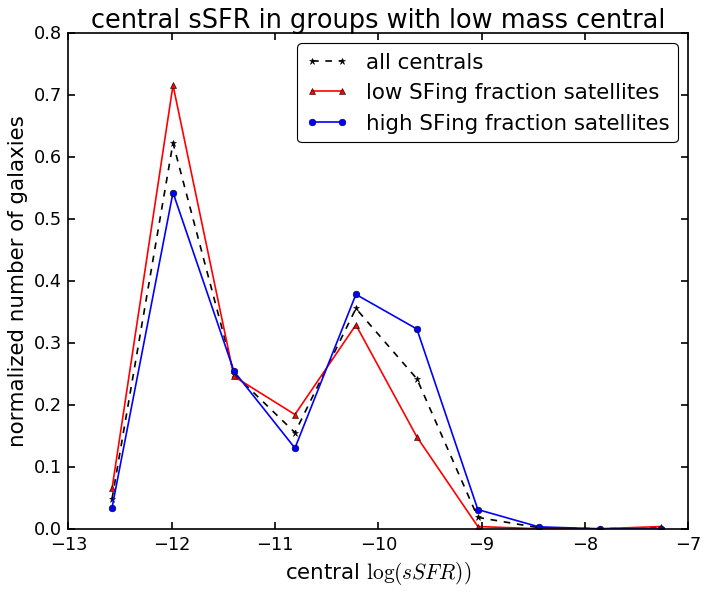

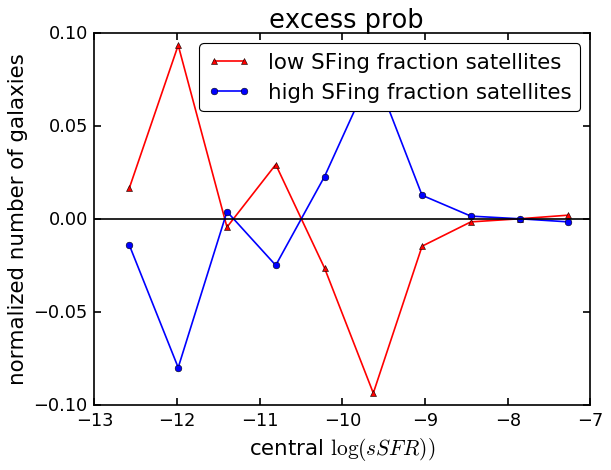

('Low SF central excess probability', array([ 0.10892326]))
('high SF central excess probability', array([ 0.13264443]))


In [57]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_LM_ssfr_hist, all_bins_LM = np.histogram(np.concatenate((AG_LM_cent_ssfr_pas_sat, AG_LM_cent_ssfr_act_sat)), density=True)
cent_LM_ssfr_pas_sat_hist, pas_bins_LM = np.histogram(AG_LM_cent_ssfr_pas_sat, bins=all_bins_LM, density=True)
cent_LM_ssfr_act_sat_hist, act_bins_LM = np.histogram(AG_LM_cent_ssfr_act_sat, bins=all_bins_LM, density=True)

all_binsize_LM = all_bins_LM[2] - all_bins_LM[1]
pas_binsize_LM = pas_bins_LM[2] - pas_bins_LM[1]
act_binsize_LM = act_bins_LM[2] - act_bins_LM[1]

D, p_val = ks_2samp(AG_LM_cent_ssfr_pas_sat, AG_LM_cent_ssfr_act_sat)
print('p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: '+str(p_val))

plt.plot(all_bins_LM[1:] - all_binsize_LM/2, cent_LM_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
plt.plot(pas_bins_LM[1:] - pas_binsize_LM/2, cent_LM_ssfr_pas_sat_hist, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_LM[1:] - act_binsize_LM/2, cent_LM_ssfr_act_sat_hist, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups with low mass central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(12.5, 15)
plt.show()

plt.plot(pas_bins_LM[1:] - pas_binsize_LM/2, cent_LM_ssfr_pas_sat_hist - cent_LM_ssfr_hist, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_LM[1:] - act_binsize_LM/2, cent_LM_ssfr_act_sat_hist - cent_LM_ssfr_hist, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title(' excess prob')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = all_bins_LM[1:] - all_binsize_LM/2
low_sfr_ind =[np.where(bins < -11)]
low_sfr_bins = bins[low_sfr_ind]
low_sfr_act = cent_LM_ssfr_act_sat_hist[low_sfr_ind]
low_sfr_pas = cent_LM_ssfr_pas_sat_hist[low_sfr_ind]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_ind =[np.where(bins >= -11)]
high_sfr_bins = bins[high_sfr_ind]
high_sfr_act= cent_LM_ssfr_act_sat_hist[high_sfr_ind]
high_sfr_pas = cent_LM_ssfr_pas_sat_hist[high_sfr_ind]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: 1.80042093157e-16


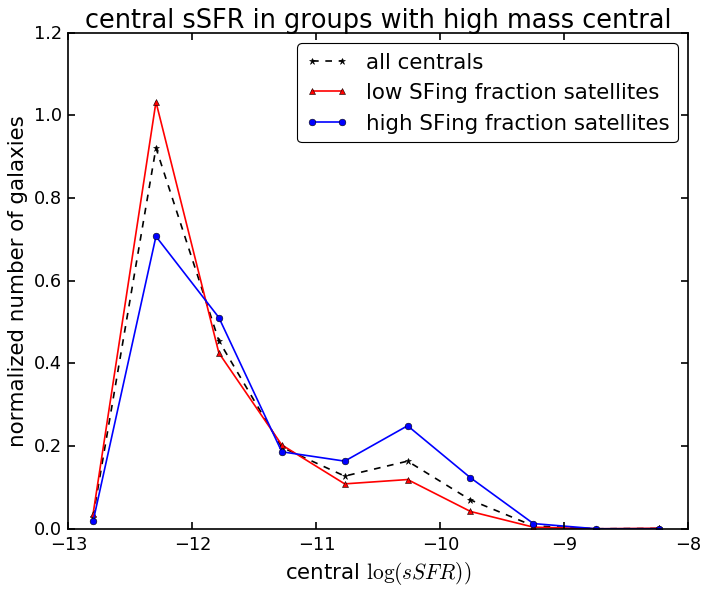

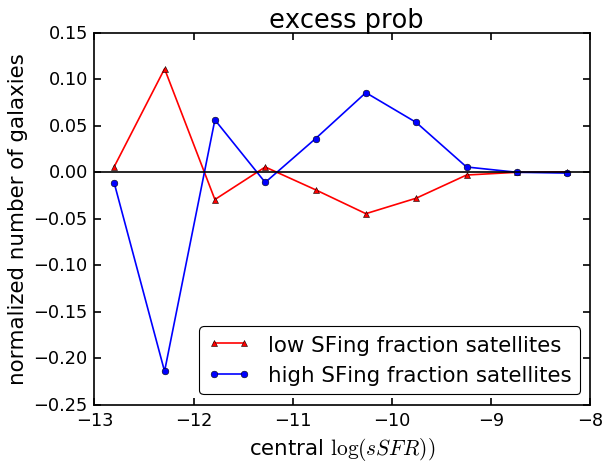

('Low SF central excess probability', array([ 0.13027329]))
('high SF central excess probability', array([ 0.12535554]))


In [62]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_HM_ssfr_hist, all_bins_HM = np.histogram(np.concatenate((AG_HM_cent_ssfr_pas_sat, AG_HM_cent_ssfr_act_sat)), density=True)
cent_HM_ssfr_pas_sat_hist, pas_bins_HM = np.histogram(AG_HM_cent_ssfr_pas_sat, bins=all_bins_HM, density=True)
cent_HM_ssfr_act_sat_hist, act_bins_HM = np.histogram(AG_HM_cent_ssfr_act_sat, bins=all_bins_HM, density=True)

all_binsize_HM = all_bins_HM[2] - all_bins_HM[1]
pas_binsize_HM = pas_bins_HM[2] - pas_bins_HM[1]
act_binsize_HM = act_bins_HM[2] - act_bins_HM[1]

D, p_val = ks_2samp(AG_HM_cent_ssfr_pas_sat, AG_HM_cent_ssfr_act_sat)
print('p value of KS test on high star-forming satellite centrals, low star-forming satellite centrals: '+str(p_val))

plt.plot(all_bins_HM[1:] - all_binsize_HM/2, cent_HM_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
plt.plot(pas_bins_HM[1:] - pas_binsize_HM/2, cent_HM_ssfr_pas_sat_hist, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_HM[1:] - act_binsize_HM/2, cent_HM_ssfr_act_sat_hist, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('central sSFR in groups with high mass central')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
#plt.xlim(12.5, 15)
plt.show()

plt.plot(pas_bins_HM[1:] - pas_binsize_HM/2, cent_HM_ssfr_pas_sat_hist - cent_HM_ssfr_hist, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(act_bins_HM[1:] - act_binsize_HM/2, cent_HM_ssfr_act_sat_hist - cent_HM_ssfr_hist, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title(' excess prob')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central '+r'$\log (sSFR))$')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = all_bins_HM[1:] - all_binsize_HM/2
low_sfr_ind =[np.where(bins < -11)]
low_sfr_bins = bins[low_sfr_ind]
low_sfr_act = cent_HM_ssfr_act_sat_hist[low_sfr_ind]
low_sfr_pas = cent_HM_ssfr_pas_sat_hist[low_sfr_ind]
excess_low = np.abs(np.trapz(low_sfr_act, low_sfr_bins) - np.trapz(low_sfr_pas, low_sfr_bins))
print('Low SF central excess probability', excess_low)

high_sfr_ind =[np.where(bins >= -11)]
high_sfr_bins = bins[high_sfr_ind]
high_sfr_act= cent_HM_ssfr_act_sat_hist[high_sfr_ind]
high_sfr_pas = cent_HM_ssfr_pas_sat_hist[high_sfr_ind]
excess_high = np.abs(np.trapz(high_sfr_act, high_sfr_bins) - np.trapz(high_sfr_pas, high_sfr_bins))
print('high SF central excess probability', excess_high)

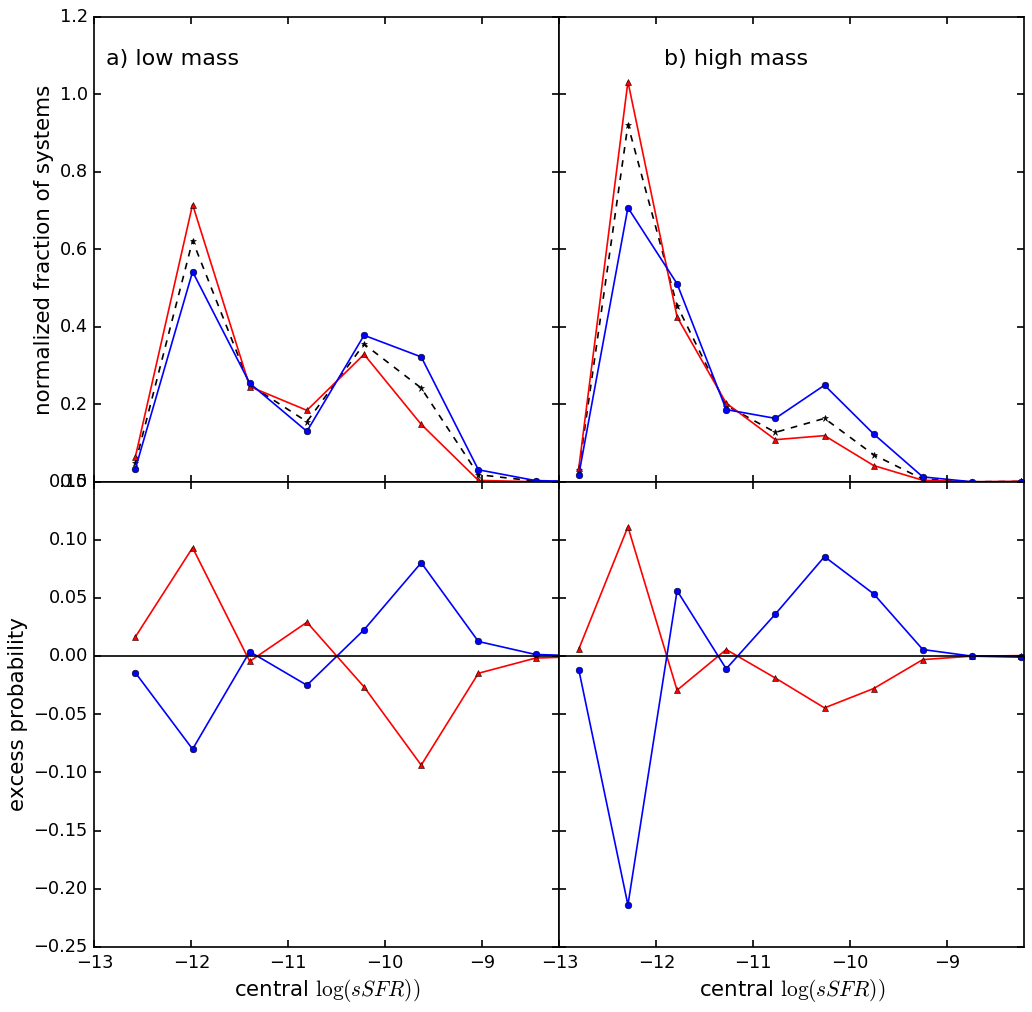

In [63]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='row', sharex='col')
f.set_figheight(15)
f.set_figwidth(15)

ax1.plot(all_bins_LM[1:] - all_binsize_LM/2, cent_LM_ssfr_hist, c='k', marker='*', label='all centrals',linestyle='--')
ax1.plot(pas_bins_LM[1:] - pas_binsize_LM/2, cent_LM_ssfr_pas_sat_hist, c='r', marker='^', label='low SFing fraction satellites')
ax1.plot(act_bins_LM[1:] - act_binsize_LM/2, cent_LM_ssfr_act_sat_hist, c='b', marker='o', label='high SFing fraction satellites')
#ax1.legend()
ax1.set_ylabel('normalized fraction of systems')
#ax1.set_xlabel('central '+r'$\log(sSFR)$')
#ax1.set_ylim(0, 1.5)
ax1.set_xlim(-13, -8.2)

ax2.plot(all_bins_HM[1:] - all_binsize_HM/2, cent_HM_ssfr_hist, c='k', marker='*', label='all',linestyle='--')
ax2.plot(pas_bins_HM[1:] - pas_binsize_HM/2, cent_HM_ssfr_pas_sat_hist, c='r', marker='^', label='low SF')
ax2.plot(act_bins_HM[1:] - act_binsize_HM/2, cent_HM_ssfr_act_sat_hist, c='b', marker='o', label='high SF')
#ax2.set_ylabel('fraction')
ax2.set_xlim(-13, -8.2)
plt.legend()
#ax2.set_xlabel('central '+r'$\log (sSFR))$')

ax3.plot(pas_bins_LM[1:] - pas_binsize_LM/2, cent_LM_ssfr_pas_sat_hist - cent_LM_ssfr_hist, c='r', marker='^', label='low SF')
ax3.plot(act_bins_LM[1:] - act_binsize_LM/2, cent_LM_ssfr_act_sat_hist - cent_LM_ssfr_hist, c='b', marker='o', label='high SF')
ax3.set_ylabel('excess probability')
ax3.axhline(0,c='k')
ax3.set_xlabel('central '+r'$\log (sSFR))$')

ax4.plot(pas_bins_HM[1:] - pas_binsize_HM/2, cent_HM_ssfr_pas_sat_hist - cent_HM_ssfr_hist, c='r', marker='^', label='low SF')
ax4.plot(act_bins_HM[1:] - act_binsize_HM/2, cent_HM_ssfr_act_sat_hist - cent_HM_ssfr_hist, c='b', marker='o', label='high SF')
ax4.set_xlabel('central '+r'$\log (sSFR))$')
ax4.axhline(0,c='k')

f.subplots_adjust(wspace=0, hspace=0)

f.text(0.135, 0.86,'a) low mass',fontsize=20)
f.text(0.6, 0.86,'b) high mass',fontsize=20)
plt.savefig('../plots/ssfr_hist_mass.png',dpi=300)

p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.000338348673545


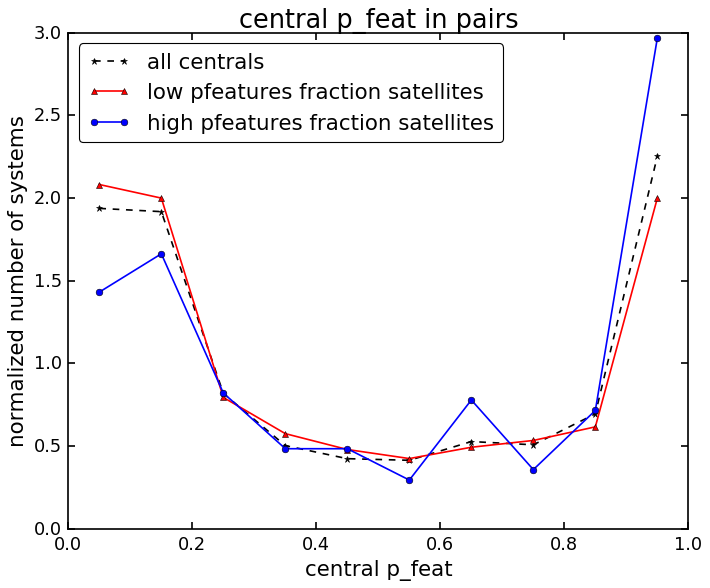

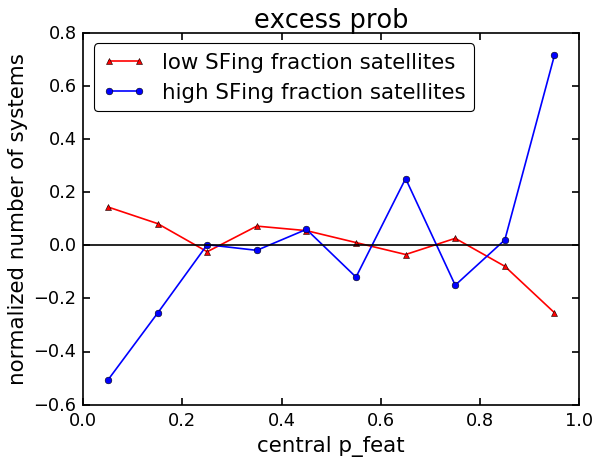

('Smooth central excess probability', array([ 0.04937275]))
('Spiral central excess probability', array([ 0.05338861]))


In [68]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_pfeat_hist_SG, all_bins_SG = np.histogram(np.concatenate((SG_cent_pfeat_smooth_sat, SG_cent_pfeat_spiral_sat, SG_cent_pfeat_int_sat)), density=True)
cent_pfeat_smooth_sat_hist_SG,smooth_bins_SG = np.histogram(SG_cent_pfeat_smooth_sat, bins=all_bins_SG, density=True)
cent_pfeat_spiral_sat_hist_SG,spiral_bins_SG = np.histogram(SG_cent_pfeat_spiral_sat, bins=all_bins_SG, density=True)
cent_pfeat_int_sat_hist_SG,int_bins_SG = np.histogram(SG_cent_pfeat_int_sat, bins=all_bins_SG, density=True)

all_binsize_SG = all_bins_SG[2] - all_bins_SG[1]
smooth_binsize_SG = smooth_bins_SG[2] - smooth_bins_SG[1]
spiral_binsize_SG = spiral_bins_SG[2] - spiral_bins_SG[1]
int_binsize_SG = int_bins_SG[2] - int_bins_SG[1]

D, p_val = ks_2samp(SG_cent_pfeat_smooth_sat, SG_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

plt.plot(all_bins_SG[1:] - all_binsize_SG/2, cent_pfeat_hist_SG, c='k', marker='*', label='all centrals', linestyle='--')
plt.plot(smooth_bins_SG[1:] - smooth_binsize_SG/2, cent_pfeat_smooth_sat_hist_SG, c='r', marker='^', label='low pfeatures fraction satellites')
plt.plot(spiral_bins_SG[1:] - spiral_binsize_SG/2, cent_pfeat_spiral_sat_hist_SG, c='b', marker='o', label='high pfeatures fraction satellites')
#plt.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate pfeatures fraction satellites')
plt.legend()
plt.title('central p_feat in pairs')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
#plt.xlim(-0.01, 1.01)
plt.show()

plt.plot(smooth_bins_SG[1:] - smooth_binsize_SG/2, cent_pfeat_smooth_sat_hist_SG - cent_pfeat_hist_SG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(spiral_bins_SG[1:] - spiral_binsize_SG/2, cent_pfeat_spiral_sat_hist_SG - cent_pfeat_hist_SG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = all_bins_SG[1:] - all_binsize_SG/2
smooth_ind =[np.where(bins <= 0.2)]
smooth_bins = bins[smooth_ind]
smooth_spiral = cent_pfeat_spiral_sat_hist_SG[smooth_ind]
smooth_smooth = cent_pfeat_smooth_sat_hist_SG[smooth_ind]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_ind =[np.where(bins >= 0.8)]
spiral_bins = bins[spiral_ind]
spiral_spiral = cent_pfeat_spiral_sat_hist_SG[spiral_ind]
spiral_smooth = cent_pfeat_smooth_sat_hist_SG[spiral_ind]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.0546378668464


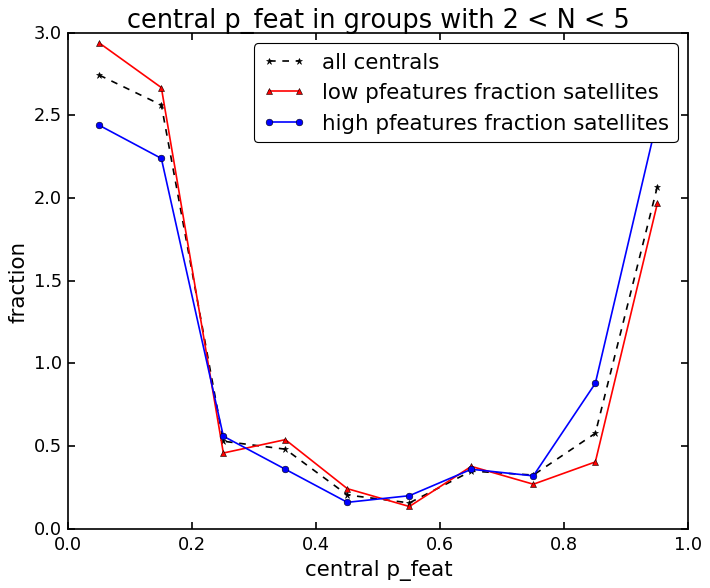

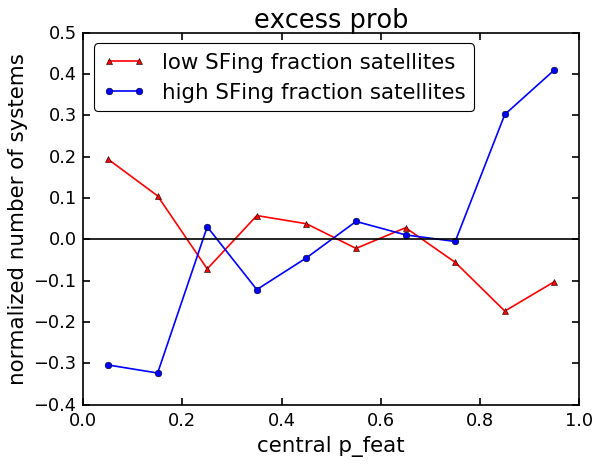

('Smooth central excess probability', array([ 0.04632345]))
('Spiral central excess probability', array([ 0.04940162]))


In [70]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_pfeat_hist_LG, all_bins_LG = np.histogram(np.concatenate((LG_cent_pfeat_smooth_sat, LG_cent_pfeat_spiral_sat, LG_cent_pfeat_int_sat)), density=True)
cent_pfeat_smooth_sat_hist_LG,smooth_bins_LG = np.histogram(LG_cent_pfeat_smooth_sat, bins=all_bins_LG, density=True)
cent_pfeat_spiral_sat_hist_LG,spiral_bins_LG = np.histogram(LG_cent_pfeat_spiral_sat, bins=all_bins_LG, density=True)
cent_pfeat_int_sat_hist_LG,int_bins_LG = np.histogram(LG_cent_pfeat_int_sat, bins=all_bins_LG, density=True)

all_binsize_LG = all_bins_LG[2] - all_bins_LG[1]
smooth_binsize_LG = smooth_bins_LG[2] - smooth_bins_LG[1]
spiral_binsize_LG = spiral_bins_LG[2] - spiral_bins_LG[1]
int_binsize_LG = int_bins_LG[2] - int_bins_LG[1]

D, p_val = ks_2samp(LG_cent_pfeat_smooth_sat, LG_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

plt.plot(all_bins_LG[1:] - all_binsize_LG/2, cent_pfeat_hist_LG, c='k', marker='*', label='all centrals', linestyle='--')
plt.plot(smooth_bins_LG[1:] - smooth_binsize_LG/2, cent_pfeat_smooth_sat_hist_LG, c='r', marker='^', label='low pfeatures fraction satellites')
plt.plot(spiral_bins_LG[1:] - spiral_binsize_LG/2, cent_pfeat_spiral_sat_hist_LG, c='b', marker='o', label='high pfeatures fraction satellites')
#plt.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate pfeatures fraction satellites')
plt.legend()
plt.title('central p_feat in groups with 2 < N < 5')
plt.ylabel('fraction')
plt.xlabel('central p_feat')
#plt.xlim(-0.01, 1.01)
plt.show()

plt.plot(smooth_bins_LG[1:] - smooth_binsize_LG/2, cent_pfeat_smooth_sat_hist_LG - cent_pfeat_hist_LG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(spiral_bins_LG[1:] - spiral_binsize_LG/2, cent_pfeat_spiral_sat_hist_LG - cent_pfeat_hist_LG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = all_bins_LG[1:] - all_binsize_LG/2
smooth_ind =[np.where(bins <= 0.2)]
smooth_bins = bins[smooth_ind]
smooth_spiral = cent_pfeat_spiral_sat_hist_LG[smooth_ind]
smooth_smooth = cent_pfeat_smooth_sat_hist_LG[smooth_ind]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_ind =[np.where(bins >= 0.8)]
spiral_bins = bins[spiral_ind]
spiral_spiral = cent_pfeat_spiral_sat_hist_LG[spiral_ind]
spiral_smooth = cent_pfeat_smooth_sat_hist_LG[spiral_ind]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.221216337569


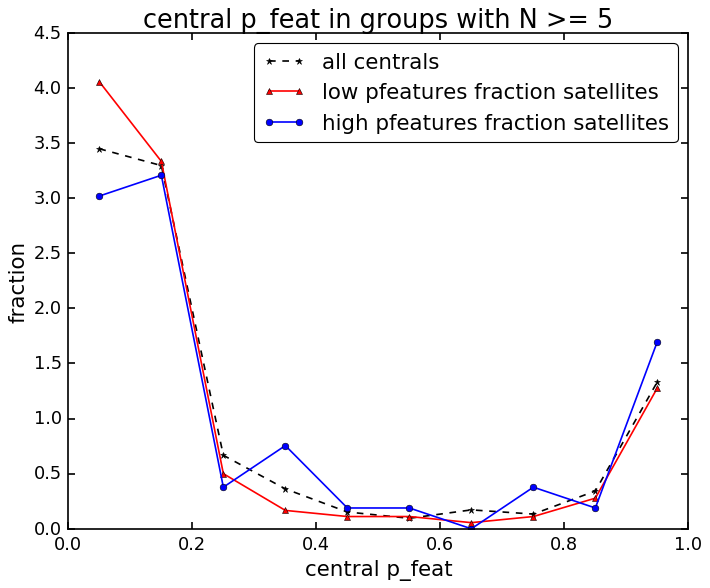

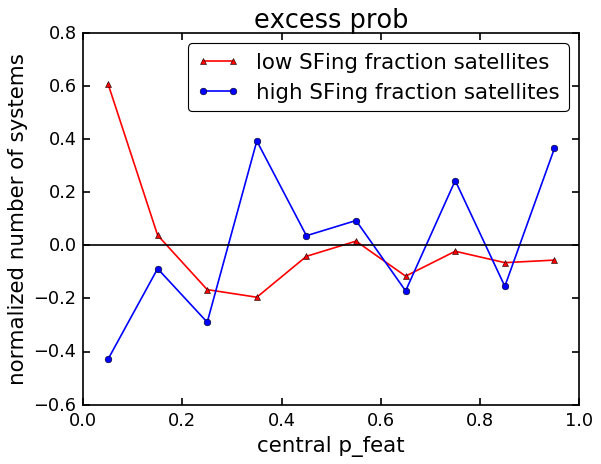

('Smooth central excess probability', array([ 0.05812369]))
('Spiral central excess probability', array([ 0.01656184]))


In [71]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_pfeat_hist_VLG, all_bins_VLG = np.histogram(np.concatenate((VLG_cent_pfeat_smooth_sat, VLG_cent_pfeat_spiral_sat, VLG_cent_pfeat_int_sat)), density=True)
cent_pfeat_smooth_sat_hist_VLG,smooth_bins_VLG = np.histogram(VLG_cent_pfeat_smooth_sat, bins=all_bins_VLG, density=True)
cent_pfeat_spiral_sat_hist_VLG,spiral_bins_VLG = np.histogram(VLG_cent_pfeat_spiral_sat, bins=all_bins_VLG, density=True)
cent_pfeat_int_sat_hist_VLG,int_bins_VLG = np.histogram(VLG_cent_pfeat_int_sat, bins=all_bins_VLG, density=True)

all_binsize_VLG = all_bins_VLG[2] - all_bins_VLG[1]
smooth_binsize_VLG = smooth_bins_VLG[2] - smooth_bins_VLG[1]
spiral_binsize_VLG = spiral_bins_VLG[2] - spiral_bins_VLG[1]
int_binsize_VLG = int_bins_VLG[2] - int_bins_VLG[1]

D, p_val = ks_2samp(VLG_cent_pfeat_smooth_sat, VLG_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

plt.plot(all_bins_VLG[1:] - all_binsize_VLG/2, cent_pfeat_hist_VLG, c='k', marker='*', label='all centrals', linestyle='--')
plt.plot(smooth_bins_VLG[1:] - smooth_binsize_VLG/2, cent_pfeat_smooth_sat_hist_VLG, c='r', marker='^', label='low pfeatures fraction satellites')
plt.plot(spiral_bins_VLG[1:] - spiral_binsize_VLG/2, cent_pfeat_spiral_sat_hist_VLG, c='b', marker='o', label='high pfeatures fraction satellites')
#plt.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate pfeatures fraction satellites')
plt.legend()
plt.title('central p_feat in groups with N >= 5')
plt.ylabel('fraction')
plt.xlabel('central p_feat')
#plt.xlim(-0.01, 1.01)
plt.show()

plt.plot(smooth_bins_VLG[1:] - smooth_binsize_VLG/2, cent_pfeat_smooth_sat_hist_VLG - cent_pfeat_hist_VLG, c='r', marker='^', label='low SFing fraction satellites')
plt.plot(spiral_bins_VLG[1:] - spiral_binsize_VLG/2, cent_pfeat_spiral_sat_hist_VLG - cent_pfeat_hist_VLG, c='b', marker='o', label='high SFing fraction satellites')
plt.legend()
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = all_bins_VLG[1:] - all_binsize_VLG/2
smooth_ind =[np.where(bins <= 0.2)]
smooth_bins = bins[smooth_ind]
smooth_spiral = cent_pfeat_spiral_sat_hist_VLG[smooth_ind]
smooth_smooth = cent_pfeat_smooth_sat_hist_VLG[smooth_ind]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_ind =[np.where(bins >= 0.8)]
spiral_bins = bins[spiral_ind]
spiral_spiral = cent_pfeat_spiral_sat_hist_VLG[spiral_ind]
spiral_smooth = cent_pfeat_smooth_sat_hist_VLG[spiral_ind]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

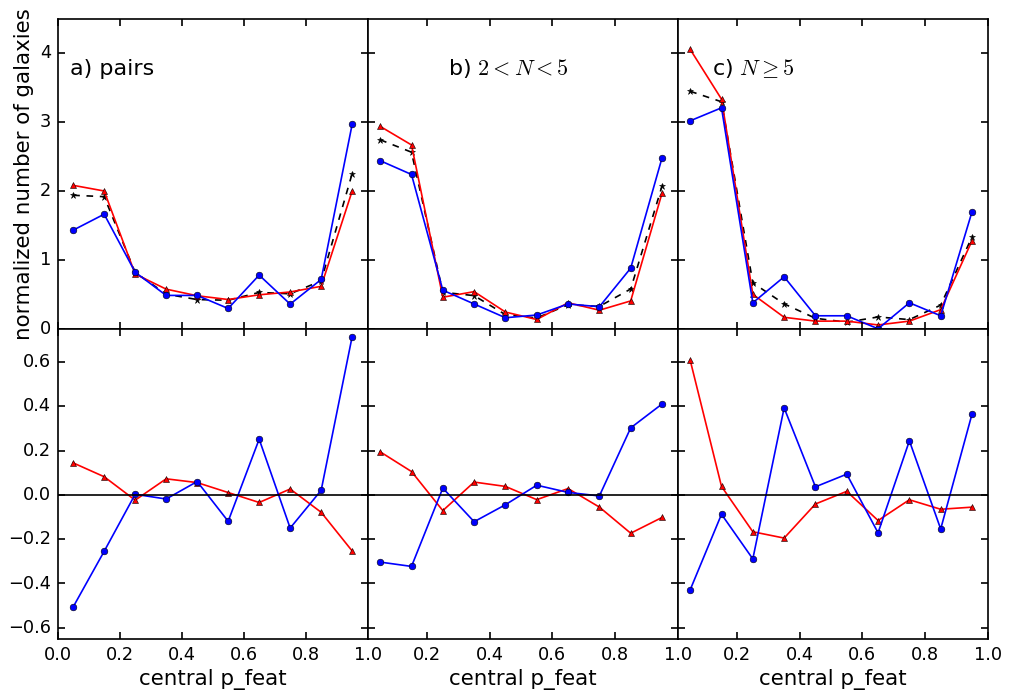

In [76]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey='row', sharex='col')
f.set_figheight(10)
f.set_figwidth(15)

ax1.plot(all_bins_SG[1:] - all_binsize_SG/2, cent_pfeat_hist_SG, c='k', marker='*', label='all centrals', linestyle='--')
ax1.plot(smooth_bins_SG[1:] - smooth_binsize_SG/2, cent_pfeat_smooth_sat_hist_SG, c='r', marker='^', label='low pfeatures fraction satellites')
ax1.plot(spiral_bins_SG[1:] - spiral_binsize_SG/2, cent_pfeat_spiral_sat_hist_SG, c='b', marker='o', label='high pfeatures fraction satellites')
#ax1.plot(int_bins2[1:] - int_binsize2/2, cent_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
ax1.set_ylabel('normalized number of galaxies')
#ax1.set_xlabel('central p_feat')
#ax1.set_ylim(0, 1.5)
ax1.set_xlim(0, 1.)
ax1.set_ylim(0,4.5)
start, end = ax1.get_ylim()
ax1.yaxis.set_ticks(np.arange(start, end, 1))

ax2.plot(all_bins_LG[1:] - all_binsize_LG/2, cent_pfeat_hist_LG, c='k', marker='*', label='all', linestyle='--')
ax2.plot(smooth_bins_LG[1:] - smooth_binsize_LG/2, cent_pfeat_smooth_sat_hist_LG, c='r', marker='^', label='smooth')
ax2.plot(spiral_bins_LG[1:] - spiral_binsize_LG/2, cent_pfeat_spiral_sat_hist_LG, c='b', marker='o', label='featured')
#ax2.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
ax2.set_xlim(0.01, 1)
#ax2.set_xlabel('central p_feat')

ax3.plot(all_bins_VLG[1:] - all_binsize_VLG/2, cent_pfeat_hist_VLG, c='k', marker='*', label='all', linestyle='--')
ax3.plot(smooth_bins_VLG[1:] - smooth_binsize_VLG/2, cent_pfeat_smooth_sat_hist_VLG, c='r', marker='^', label='smooth')
ax3.plot(spiral_bins_VLG[1:] - spiral_binsize_VLG/2, cent_pfeat_spiral_sat_hist_VLG, c='b', marker='o', label='featured')
#ax3.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
plt.legend()
ax3.set_xlim(0.01, 1)
#ax3.set_xlabel('central p_feat')

ax4.plot(smooth_bins_SG[1:] - smooth_binsize_SG/2, cent_pfeat_smooth_sat_hist_SG - cent_pfeat_hist_SG, c='r', marker='^', label='smooth')
ax4.plot(spiral_bins_SG[1:] - spiral_binsize_SG/2, cent_pfeat_spiral_sat_hist_SG - cent_pfeat_hist_SG, c='b', marker='o', label='featured')
#ax4.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
ax4.axhline(0,c='k')
ax4.set_xlabel('central p_feat')
ax4.set_ylim(-.65, .75)

ax5.plot(smooth_bins_LG[1:] - smooth_binsize_LG/2, cent_pfeat_smooth_sat_hist_LG - cent_pfeat_hist_LG, c='r', marker='^', label='smooth')
ax5.plot(spiral_bins_LG[1:] - spiral_binsize_LG/2, cent_pfeat_spiral_sat_hist_LG - cent_pfeat_hist_LG, c='b', marker='o', label='featured')
#ax3.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
ax5.set_xlabel('central p_feat')
ax5.axhline(0,c='k')

ax6.plot(smooth_bins_VLG[1:] - smooth_binsize_VLG/2, cent_pfeat_smooth_sat_hist_VLG - cent_pfeat_hist_VLG, c='r', marker='^', label='smooth')
ax6.plot(spiral_bins_VLG[1:] - spiral_binsize_VLG/2, cent_pfeat_spiral_sat_hist_VLG - cent_pfeat_hist_VLG, c='b', marker='o', label='featured')
#ax3.plot(int_bins[1:] - int_binsize/2, cent_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
ax6.axhline(0,c='k')
ax6.set_xlabel('central p_feat')

f.subplots_adjust(wspace=0, hspace=0)

f.text(0.135, 0.83,'a) pairs',fontsize=20)
f.text(0.45, 0.83,r'b) $2 < N < 5$',fontsize=20)
f.text(0.67, 0.83,r'c) $N \geq 5$',fontsize=20)

plt.savefig('../plots/pfeat_hist.png',dpi=300)

p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.000544003541449


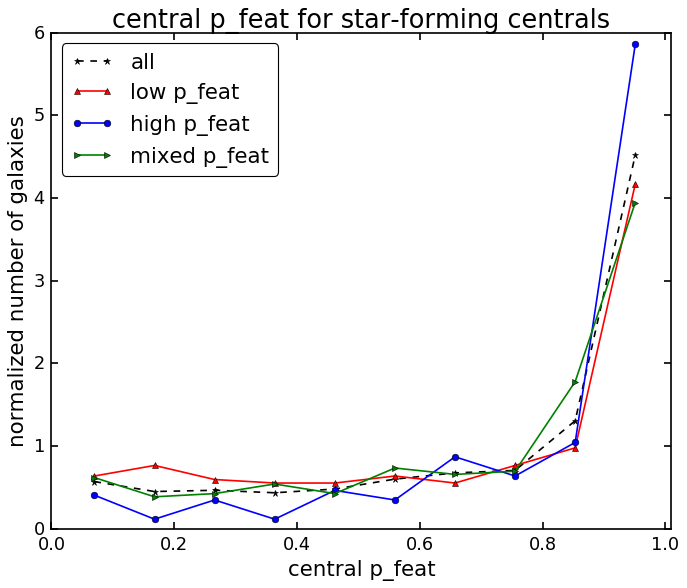

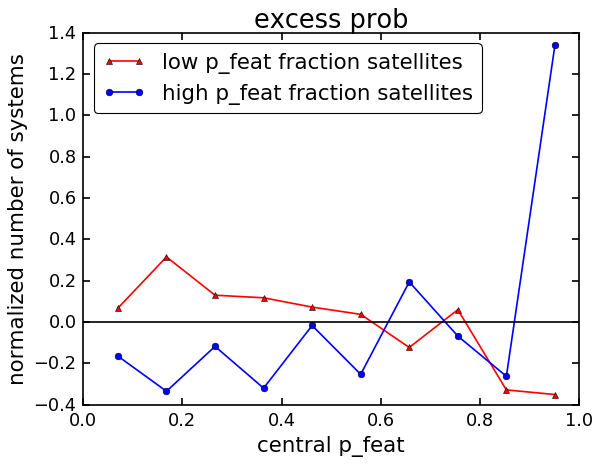

('Smooth central excess probability', array([ 0.04318182]))
('Spiral central excess probability', array([ 0.08598485]))


In [86]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_active_pfeat_hist, all_bins = np.histogram(np.concatenate((AG_active_cent_pfeat_smooth_sat, AG_active_cent_pfeat_spiral_sat, AG_active_cent_pfeat_mixed_sat)), density=True)
cent_active_pfeat_smooth_sat_hist,smooth_bins = np.histogram(AG_active_cent_pfeat_smooth_sat, bins=all_bins, density=True)
cent_active_pfeat_spiral_sat_hist,spiral_bins = np.histogram(AG_active_cent_pfeat_spiral_sat, bins=all_bins, density=True)
cent_active_pfeat_int_sat_hist,int_bins = np.histogram(AG_active_cent_pfeat_mixed_sat, bins=all_bins, density=True)

all_binsize = all_bins[2] - all_bins[1]
smooth_binsize = smooth_bins[2] - smooth_bins[1]
spiral_binsize = spiral_bins[2] - spiral_bins[1]
int_binsize = int_bins[2] - int_bins[1]

D, p_val = ks_2samp(AG_active_cent_pfeat_smooth_sat, AG_active_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

plt.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_hist, c='k', marker='*', label='all', linestyle='--')
plt.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_smooth_sat_hist, c='r', marker='^', label='low p_feat')
plt.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_spiral_sat_hist, c='b', marker='o', label='high p_feat')
plt.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_int_sat_hist, c='g', marker='>', label='mixed p_feat')
plt.legend()
plt.title('central p_feat for star-forming centrals')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central p_feat')
plt.xlim(0, 1.01)
plt.show()

plt.plot(smooth_bins[1:] - smooth_binsize/2, cent_active_pfeat_smooth_sat_hist - cent_active_pfeat_hist, c='r', marker='^', label='low p_feat fraction satellites')
plt.plot(spiral_bins[1:] - spiral_binsize/2, cent_active_pfeat_spiral_sat_hist - cent_active_pfeat_hist, c='b', marker='o', label='high p_feat fraction satellites')
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.legend()
plt.show()

bins = all_bins[1:] - all_binsize/2
smooth_ind =[np.where(bins <= 0.2)]
smooth_bins = bins[smooth_ind]
smooth_spiral = cent_active_pfeat_spiral_sat_hist[smooth_ind]
smooth_smooth = cent_active_pfeat_smooth_sat_hist[smooth_ind]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_ind =[np.where(bins >= 0.8)]
spiral_bins = bins[spiral_ind]
spiral_spiral = cent_active_pfeat_spiral_sat_hist[spiral_ind]
spiral_smooth = cent_active_pfeat_smooth_sat_hist[spiral_ind]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.000114555782952


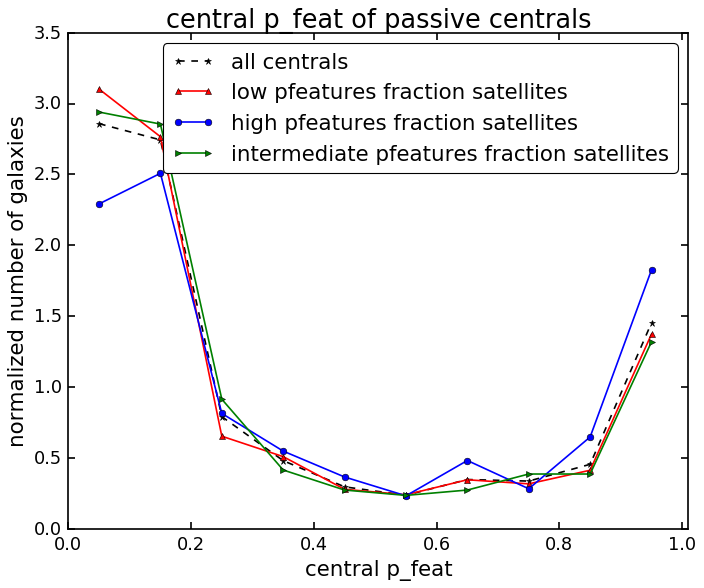

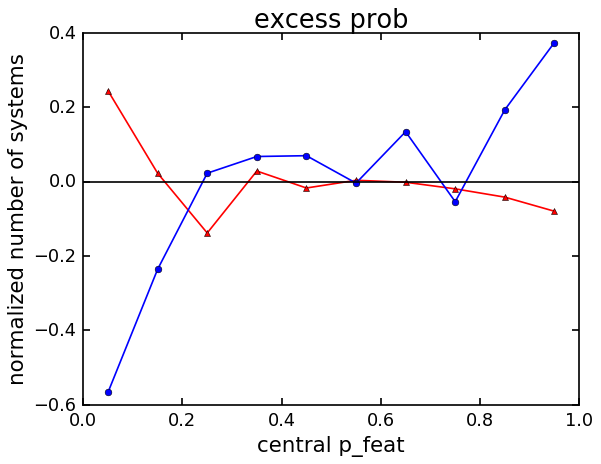

('Smooth central excess probability', array([ 0.0534346]))
('Spiral central excess probability', array([ 0.03441698]))


In [83]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_passive_pfeat_hist, all_bins2 = np.histogram(np.concatenate((AG_passive_cent_pfeat_smooth_sat, AG_passive_cent_pfeat_spiral_sat, AG_passive_cent_pfeat_mixed_sat)), density=True)
cent_passive_pfeat_smooth_sat_hist,smooth_bins2 = np.histogram(AG_passive_cent_pfeat_smooth_sat, bins=all_bins2, density=True)
cent_passive_pfeat_spiral_sat_hist,spiral_bins2 = np.histogram(AG_passive_cent_pfeat_spiral_sat, bins=all_bins2, density=True)
cent_passive_pfeat_int_sat_hist,int_bins2= np.histogram(AG_passive_cent_pfeat_mixed_sat, bins=all_bins2, density=True)

all_binsize2 = all_bins2[2] - all_bins2[1]
smooth_binsize2 = smooth_bins2[2] - smooth_bins2[1]
spiral_binsize2 = spiral_bins2[2] - spiral_bins2[1]
int_binsize2 = int_bins2[2] - int_bins2[1]

D, p_val = ks_2samp(AG_passive_cent_pfeat_smooth_sat, AG_passive_cent_pfeat_spiral_sat)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

plt.plot(all_bins2[1:] - all_binsize2/2, cent_passive_pfeat_hist, c='k', marker='*', label='all centrals', linestyle='--')
plt.plot(smooth_bins2[1:] - smooth_binsize2/2, cent_passive_pfeat_smooth_sat_hist, c='r', marker='^', label='low pfeatures fraction satellites')
plt.plot(spiral_bins2[1:] - spiral_binsize2/2, cent_passive_pfeat_spiral_sat_hist, c='b', marker='o', label='high pfeatures fraction satellites')
plt.plot(int_bins2[1:] - int_binsize2/2, cent_passive_pfeat_int_sat_hist, c='g', marker='>', label='intermediate pfeatures fraction satellites')
plt.legend()
plt.title('central p_feat of passive centrals')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central p_feat')
plt.xlim(0, 1.01)
plt.show()

plt.plot(smooth_bins2[1:] - smooth_binsize2/2, cent_passive_pfeat_smooth_sat_hist - cent_passive_pfeat_hist, c='r', marker='^', label='low p_feat fraction satellites')
plt.plot(spiral_bins2[1:] - spiral_binsize2/2, cent_passive_pfeat_spiral_sat_hist - cent_passive_pfeat_hist, c='b', marker='o', label='high p_feat fraction satellites')
plt.title('excess prob')
plt.ylabel('normalized number of systems')
plt.xlabel('central p_feat')
plt.axhline(0,c='k')
#plt.xlim(12.5, 15)
plt.show()

bins = all_bins2[1:] - all_binsize2/2
smooth_ind =[np.where(bins <= 0.2)]
smooth_bins = bins[smooth_ind]
smooth_spiral = cent_passive_pfeat_spiral_sat_hist[smooth_ind]
smooth_smooth = cent_passive_pfeat_smooth_sat_hist[smooth_ind]
excess_low = np.abs(np.trapz(smooth_spiral, smooth_bins) - np.trapz(smooth_smooth, smooth_bins))
print('Smooth central excess probability', excess_low)
           
spiral_ind =[np.where(bins >= 0.8)]
spiral_bins = bins[spiral_ind]
spiral_spiral = cent_passive_pfeat_spiral_sat_hist[spiral_ind]
spiral_smooth = cent_passive_pfeat_smooth_sat_hist[spiral_ind]
excess_high = np.abs(np.trapz(spiral_spiral, spiral_bins) - np.trapz(spiral_smooth, spiral_bins))
print('Spiral central excess probability', excess_high)

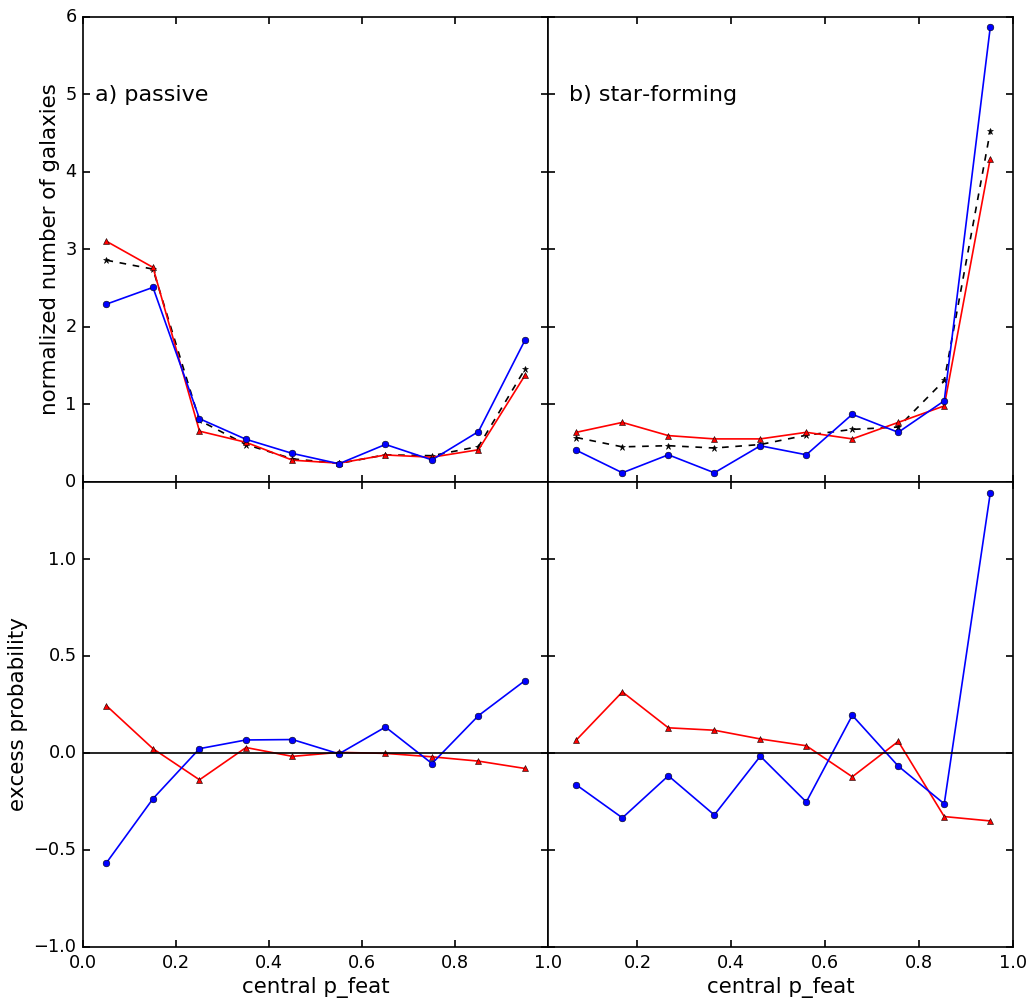

In [88]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='row', sharex='col')
f.set_figheight(15)
f.set_figwidth(15)

ax1.plot(all_bins2[1:] - all_binsize2/2, cent_passive_pfeat_hist, c='k', marker='*', label='all centrals', linestyle='--')
ax1.plot(smooth_bins2[1:] - smooth_binsize2/2, cent_passive_pfeat_smooth_sat_hist, c='r', marker='^', label='low pfeatures fraction satellites')
ax1.plot(spiral_bins2[1:] - spiral_binsize2/2, cent_passive_pfeat_spiral_sat_hist, c='b', marker='o', label='high pfeatures fraction satellites')
#ax1.plot(int_bins2[1:] - int_binsize2/2, cent_passive_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
ax1.set_ylabel('normalized number of galaxies')
#ax1.set_xlabel('central p_feat')
#ax1.set_ylim(0, 1.5)
ax1.set_xlim(0, 1)

ax2.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_hist, c='k', marker='*', label='all', linestyle='--')
ax2.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_smooth_sat_hist, c='r', marker='^', label='smooth')
ax2.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_spiral_sat_hist, c='b', marker='o', label='featured')
#ax2.plot(int_bins[1:] - int_binsize/2, cent_active_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
#ax2.set_ylabel('fraction')
plt.legend(loc='center left')
ax2.set_xlim(0.01, 1)
#ax2.set_xlabel('central p_feat')

ax3.plot(smooth_bins2[1:] - smooth_binsize2/2, cent_passive_pfeat_smooth_sat_hist - cent_passive_pfeat_hist, c='r', marker='^', label='low pfeatures fraction satellites')
ax3.plot(spiral_bins2[1:] - spiral_binsize2/2, cent_passive_pfeat_spiral_sat_hist - cent_passive_pfeat_hist, c='b', marker='o', label='high pfeatures fraction satellites')
#ax1.plot(int_bins2[1:] - int_binsize2/2, cent_passive_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
ax3.set_ylabel('excess probability')
ax3.set_xlabel('central p_feat')
ax3.set_ylim(-1, 1.4)
ax3.axhline(0,c='k')

ax4.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_smooth_sat_hist - cent_active_pfeat_hist, c='r', marker='^', label='low pfeatures fraction satellites')
ax4.plot(all_bins[1:] - all_binsize/2, cent_active_pfeat_spiral_sat_hist - cent_active_pfeat_hist, c='b', marker='o', label='high pfeatures fraction satellites')
#ax1.plot(int_bins2[1:] - int_binsize2/2, cent_passive_pfeat_int_sat_hist, c='g', marker='>', label='intermediate')
ax4.set_xlabel('central p_feat')
#ax3.set_ylim(0, 1.5)
ax4.axhline(0,c='k')

f.subplots_adjust(wspace=0,hspace=0)

f.text(0.135, 0.83,'a) passive',fontsize=20)
f.text(0.53, 0.83,'b) star-forming',fontsize=20)

plt.savefig('../plots/pfeat_cent_ssfr.png',dpi=300)

In [84]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_avg_pfeat_smooth_sat_hist_LG,b = np.histogram(LG_cent_avg_pfeat_smooth, bins=25)
cent_avg_pfeat_spiral_sat_hist_LG,bin_edges = np.histogram(LG_cent_avg_pfeat_spiral, bins=25)
cent_avg_pfeat_int_sat_hist_LG,bin_edges = np.histogram(LG_cent_avg_pfeat_int, bins=25)
cent_avg_pfeat_hist_LG = cent_avg_pfeat_smooth_sat_hist_LG + cent_avg_pfeat_spiral_sat_hist_LG + cent_avg_pfeat_int_sat_hist_LG

D, p_val = ks_2samp(cent_avg_pfeat_spiral_sat_hist_LG, cent_avg_pfeat_smooth_sat_hist_LG)
print('before norm p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

cent_avg_pfeat_smooth_sat_hist_LG = cent_avg_pfeat_smooth_sat_hist_LG/np.sum(cent_avg_pfeat_smooth_sat_hist_LG)
cent_avg_pfeat_spiral_sat_hist_LG = cent_avg_pfeat_spiral_sat_hist_LG/np.sum(cent_avg_pfeat_spiral_sat_hist_LG)
cent_avg_pfeat_int_sat_hist_LG = cent_avg_pfeat_int_sat_hist_LG/np.sum(cent_avg_pfeat_int_sat_hist_LG)
cent_avg_pfeat_hist_LG = cent_avg_pfeat_hist_LG/np.sum(cent_avg_pfeat_hist_LG)

D, p_val = ks_2samp(cent_avg_pfeat_spiral_sat_hist_LG, cent_avg_pfeat_smooth_sat_hist_LG)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_avg_pfeat_hist_LG, c='k', marker='*', label='all centrals', linestyle='--')
plt.plot(bin_edges_adj, cent_avg_pfeat_smooth_sat_hist_LG, c='r', marker='^', label='smooth avg satllites')
plt.plot(bin_edges_adj, cent_avg_pfeat_spiral_sat_hist_LG, c='b', marker='o', label='featured avg satellites')
plt.plot(bin_edges_adj, cent_avg_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate avg satellites')
plt.legend()
plt.title('central p_feat in groups with > 2 satellites (avg)')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central p_feat')
plt.xlim(0, 1.01)

plt.close()

before norm p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.877413252798
p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.414063038086


In [85]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

cent_avg_pfeat_smooth_sat_hist_AG,b = np.histogram(AG_cent_avg_pfeat_smooth, bins=25)
cent_avg_pfeat_spiral_sat_hist_AG,bin_edges = np.histogram(AG_cent_avg_pfeat_spiral, bins=25)
cent_avg_pfeat_int_sat_hist_AG,bin_edges = np.histogram(AG_cent_avg_pfeat_int, bins=25)
cent_avg_pfeat_hist_AG = cent_avg_pfeat_smooth_sat_hist_AG + cent_avg_pfeat_spiral_sat_hist_AG + cent_avg_pfeat_int_sat_hist_AG

D, p_val = ks_2samp(cent_avg_pfeat_spiral_sat_hist_LG, cent_avg_pfeat_smooth_sat_hist_LG)
print('before norm p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

cent_avg_pfeat_smooth_sat_hist_AG = cent_avg_pfeat_smooth_sat_hist_AG/np.sum(cent_avg_pfeat_smooth_sat_hist_AG)
cent_avg_pfeat_spiral_sat_hist_AG = cent_avg_pfeat_spiral_sat_hist_AG/np.sum(cent_avg_pfeat_spiral_sat_hist_AG)
cent_avg_pfeat_int_sat_hist_AG = cent_avg_pfeat_int_sat_hist_AG/np.sum(cent_avg_pfeat_int_sat_hist_AG)
cent_avg_pfeat_hist_AG = cent_avg_pfeat_hist_AG/np.sum(cent_avg_pfeat_hist_AG)

D, p_val = ks_2samp(cent_avg_pfeat_spiral_sat_hist_AG, cent_avg_pfeat_smooth_sat_hist_AG)
print('p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: '+str(p_val))

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, cent_avg_pfeat_hist_AG, c='k', marker='*', label='all centrals', linestyle='--')
plt.plot(bin_edges_adj, cent_avg_pfeat_smooth_sat_hist_AG, c='r', marker='^', label='smooth avg satllites')
plt.plot(bin_edges_adj, cent_avg_pfeat_spiral_sat_hist_AG, c='b', marker='o', label='featured avg satellites')
plt.plot(bin_edges_adj, cent_avg_pfeat_int_sat_hist_AG, c='g', marker='>', label='intermediate avg satellites')
plt.legend()
plt.title('central p_feat in groups with > 2 satellites (avg)')
plt.ylabel('normalized number of galaxies')
plt.xlabel('central p_feat')
plt.xlim(0, 1.01)

plt.close()

before norm p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.414063038086
p value of KS test on high pfeatures satellites centrals, low pfeatures satellites centrals: 0.877413252798


In [86]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(5)
f.set_figwidth(15)

#ax1 = fig.add_subplot(221)
ax1.plot(bin_edges_adj, cent_avg_pfeat_hist_AG, c='k', marker='*', label='all centrals', linestyle='--')
ax1.plot(bin_edges_adj, cent_avg_pfeat_smooth_sat_hist_AG, c='r', marker='^', label='low pfeatures fraction satellites')
ax1.plot(bin_edges_adj, cent_avg_pfeat_spiral_sat_hist_AG, c='b', marker='o', label='high pfeatures fraction satellites')
ax1.plot(bin_edges_adj, cent_avg_pfeat_int_sat_hist_AG, c='g', marker='>', label='intermediate')
ax1.set_ylabel('normalized number of galaxies')
ax1.set_xlabel('central p_feat')
#ax1.set_ylim(0, 1.5)
#ax1.set_xlim(-15.5, -22.75)

#ax2 = fig.add_subplot(222)
ax2.plot(bin_edges_adj, cent_avg_pfeat_hist_LG, c='k', marker='*', label='all', linestyle='--')
ax2.plot(bin_edges_adj, cent_avg_pfeat_smooth_sat_hist_LG, c='r', marker='^', label='smooth')
ax2.plot(bin_edges_adj, cent_avg_pfeat_spiral_sat_hist_LG, c='b', marker='o', label='featured')
ax2.plot(bin_edges_adj, cent_avg_pfeat_int_sat_hist_LG, c='g', marker='>', label='intermediate')
#ax2.set_ylabel('fraction')
plt.legend()
ax2.set_xlabel('central p_feat')

f.subplots_adjust(wspace=0)

f.text(0.135, 0.83,'a)',fontsize=20)
f.text(0.53, 0.83,'b)',fontsize=20)
plt.close()
#plt.savefig('../plots/pfeat_hist.png',dpi=300)

In [82]:
plt.style.use(mpl_style.style1)
plt.figure(figsize=(10,20))
hist, xedges, yedges = np.histogram2d(frac_sat_sfing,cent_ssfr, 10)
print(len(cent_ssfr))
plt.imshow(hist, extent=[np.min(cent_ssfr), np.max(cent_ssfr),np.min(frac_sat_sfing), np.max(frac_sat_sfing)])
#plt.scatter(cent_ssfr, frac_sat_sfing)
plt.xlabel('central ssfr')
plt.ylabel('fraction of star-forming satellites')
plt.ylim(0,1)
plt.xlim(-12.5,-8.3)
plt.close()

3305


In [80]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(cent_ssfr, sat_ssfr, 50)
plt.imshow(hist, extent=[np.min(cent_ssfr), np.max(cent_ssfr),np.min(sat_ssfr), np.max(sat_ssfr)])
#plt.scatter(cent_ssfr, sat_ssfr)
plt.xlabel('central ssfr')
plt.ylabel('mean ssfr of satellites')
plt.ylim(-12.8,-9.2)
plt.xlim(-12.5,-8.3)
plt.close()

In [81]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(frac_sat_spiral, cent_pspiral, 15)

plt.imshow(hist, extent=[np.min(cent_pspiral), np.max(cent_pspiral),np.min(frac_sat_spiral), np.max(frac_sat_spiral)])

#plt.scatter(cent_pspiral, frac_sat_spiral)
plt.xlabel('central pfeatures')
plt.ylabel('fraction of high pfeatures satellites')
plt.close()

In [79]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(cent_pspiral, sat_pspiral_edit, 25)

plt.imshow(hist, extent=[np.min(cent_pspiral), np.max(cent_pspiral),np.min(sat_pspiral_edit), np.max(sat_pspiral_edit)])

#plt.scatter(cent_pspiral, sat_pspiral_edit)
plt.xlabel('central pfeatures')
plt.ylabel('mean pfeatures of satellites')
plt.close()

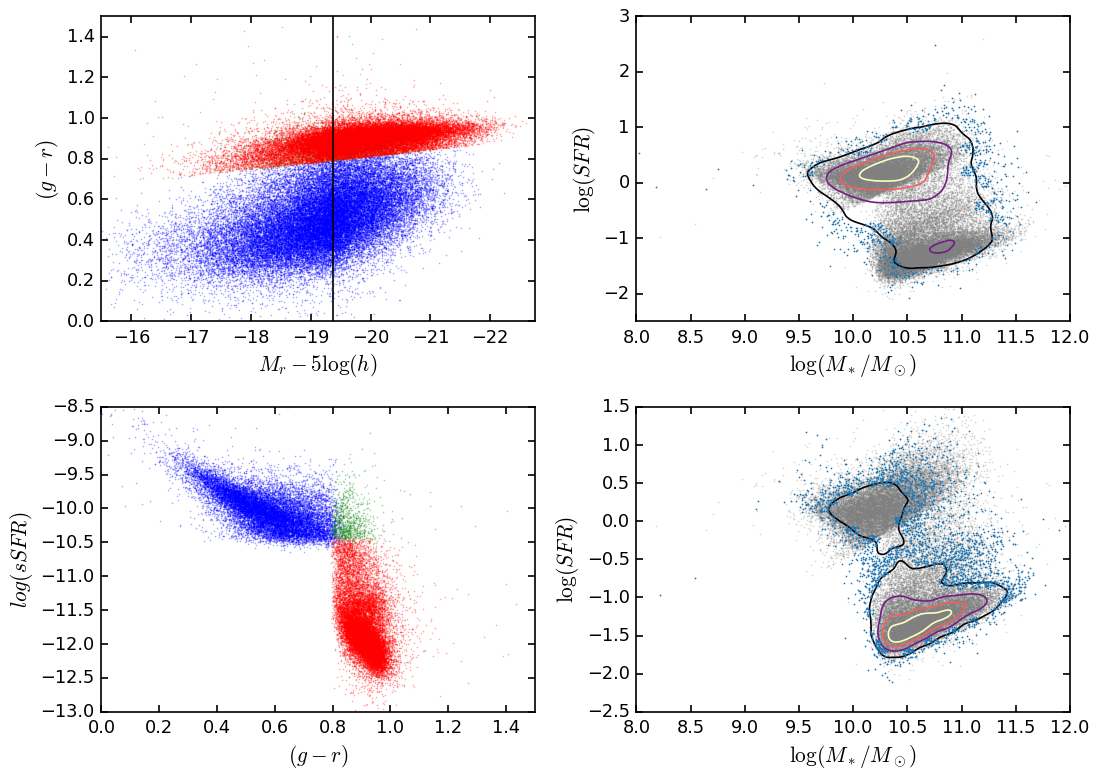

'\nplt.imshow(spiral_hist)\nplt.show()\nplt.imshow(smooth_hist)\nplt.show()'

In [91]:
fig = plt.figure(figsize=(14,10))

colors_uncut = [[x[0] for x in bluact_color_all], [x[0] for x in redact_color_all], [x[0] for x in redpas_color_all]] #this method gets the first element of the tuples
mrs_uncut = [[x[0] for x in bluact_mr_all], [x[0] for x in redact_mr_all], [x[0] for x in redpas_mr_all]]
#sfrs_uncut = [[x[0] for x in bluact_sfr_all], [x[0] for x in redact_sfr_all], [x[0] for x in redpas_sfr_all]]
#masses_uncut = [[x[0] for x in bluact_mass_all], [x[0] for x in redact_mass_all], [x[0] for x in redpas_mass_all]]

colors = [[x[0] for x in bluact_color], [x[0] for x in redact_color], [x[0] for x in redpas_color]] #this method gets the first element of the tuples
mrs = [[x[0] for x in bluact_mr], [x[0] for x in redact_mr], [x[0] for x in redpas_mr]]
sfrs = [[x[0] for x in bluact_sfr], [x[0] for x in redact_sfr], [x[0] for x in redpas_sfr]]
masses = [[x[0] for x in bluact_mass], [x[0] for x in redact_mass], [x[0] for x in redpas_mass]]

spiral_ind_all = [x[0] for x in spiral_ind]
smooth_ind_all = [x[0] for x in smooth_ind]

spiral_mass = mass[spiral_ind_all]
smooth_mass = mass[smooth_ind_all]
spiral_sfr = spiral_mass+ssfr[spiral_ind_all]
smooth_sfr = smooth_mass+ssfr[smooth_ind_all]

nonzero_spiral_ind = np.where(spiral_mass > 0)
nonzero_spiral_mass = spiral_mass[nonzero_spiral_ind]
nonzero_spiral_sfr = spiral_sfr[nonzero_spiral_ind]
nonzero_smooth_ind = np.where(smooth_mass > 0)
nonzero_smooth_mass = smooth_mass[nonzero_smooth_ind]
nonzero_smooth_sfr = smooth_sfr[nonzero_smooth_ind]

plot_color = ['b', 'g', 'r']
plt.style.use(mpl_style.style1)
#top left plot
ax1 = fig.add_subplot(221)
for i in np.arange(3):
    ax1.scatter(mrs_uncut[i], colors_uncut[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax1.set_ylabel(r'$(g-r)$')
ax1.set_xlabel(r'$M_r - 5\log(h)$')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    ax2.scatter(masses[i], np.array(masses[i])+np.array(sfrs[i]), color = 'gray', s=0.1, alpha=0.5)
#ax2.scatter(spiral_mass, spiral_sfr, color='blue')
hs.hex_contour(nonzero_spiral_mass, nonzero_spiral_sfr, min_cnt = 50, levels=4,hkwargs={'gridsize':20}) #'extent':[9,12,3,-2.5],
ax2.set_xlabel(r'$\log(M_*/M_\odot)$') 
ax2.set_ylabel(r'$\log(SFR)$')
ax2.set_ylim(-2.5, 3)
#ax2.set_xscale('log')
ax2.set_xlim(8, 12)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    ax3.scatter(colors[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
ax3.set_ylabel(r'$log(sSFR)$')
ax3.set_xlabel(r'$(g-r)$')
ax3.set_ylim(-13, -8.5)
ax3.set_xlim(0,1.5)

#bottom right plot
ax4 = fig.add_subplot(224)
for i in np.arange(3):
    ax4.scatter(masses[i], np.array(masses[i])+np.array(sfrs[i]), color = 'gray', s=0.1, alpha=0.5)
#ax4.scatter(smooth_mass, smooth_sfr, color='red')
hs.hex_contour(smooth_mass, smooth_sfr, levels = 4, min_cnt = 50)
ax4.set_xlabel(r'$\log(M_*/M_\odot)$')
ax4.set_ylabel(r'$\log(SFR)$')
ax4.set_ylim(-2.5, 1.5)
#ax4.set_xscale('log')
ax4.set_xlim(8, 12)

plt.tight_layout()
#plt.savefig('../plots/sample_plot.png', dpi=300)
plt.show()
'''
plt.imshow(spiral_hist)
plt.show()
plt.imshow(smooth_hist)
plt.show()'''